In [1]:
%pylab inline

import numpy as np
import scipy.stats as stats
import pymc3 as pm
from theano import shared
import theano
import theano.tensor as tt
floatX = "float32"

%config InlineBackend.figure_format = 'retina'
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


# PyMC3 Modeling tips and heuristic
A walkthrough of implementing a Conditional Autoregressive (CAR) model in `PyMC3`, with `WinBUGS`/`PyMC2` and `Stan` code as references.

As a probabilistic language, there are some fundamental differences between `PyMC3` and other alternatives such as `WinBUGS`, `JAGS`, and `Stan`. In this notebook, I will summarise some heuristics and intuition I got over the past two years using `PyMC3`. I will outline some thinking in how I approach a modelling problem using `PyMC3`, and how thinking in linear algebra solves most of the programming problems. I hope this notebook will shed some light onto the design and features of `PyMC3`, and similar languages that are built on linear algebra packages with a static world view (e.g., Edward, which is based on Tensorflow).  


For more resources comparing between PyMC3 codes and other probabilistic languages:
* [PyMC3 port of "Doing Bayesian Data Analysis" - PyMC3 vs WinBUGS/JAGS/Stan](https://github.com/aloctavodia/Doing_bayesian_data_analysis)
* [PyMC3 port of "Bayesian Cognitive Modeling" - PyMC3 vs WinBUGS/JAGS/Stan](https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3)
* [PyMC3 port of "Statistical Rethinking" - PyMC3 vs Stan](https://github.com/aloctavodia/Statistical-Rethinking-with-Python-and-PyMC3)

## Background information
Suppose we want to implement a [Conditional Autoregressive (CAR) model](http://www.statsref.com/HTML/index.html?car_models.html) with examples in [WinBUGS/PyMC2](http://glau.ca/?p=340) and [Stan](http://mc-stan.org/documentation/case-studies/mbjoseph-CARStan.html).  
For the sake of brevity, I will not go into the details of the CAR model. The essential idea is autocorrelation, which is informally "correlation with itself". In a CAR model, the probability of values estimated at any given location $y_i$ are conditional on some neighboring values $y_j, _{j \neq i}$ (in another word, correlated/covariated with these values):  

$$y_i \mid y_j, j \neq i \sim \mathcal{N}(\alpha \sum_{j = 1}^n b_{ij} y_j, \sigma_i^{2})$$

where $\sigma_i^{2}$ is a spatially varying covariance parameter, and $b_{ii} = 0$. 

Here we will demonstrate the implementation of a CAR model using a canonical example: the lip cancer risk data in Scotland between 1975 and 1980. The original data is from (Kemp et al. 1985). This dataset includes observed lip cancer case counts at 56 spatial units in Scotland, with the expected number of cases as intercept, and an area-specific continuous variable coded for the proportion of the population employed in agriculture, fishing, or forestry (AFF). We want to model how lip cancer rates (`O` below) relate to AFF (`aff` below), as exposure to sunlight is a risk factor.

$$O_i \sim \mathcal{Poisson}(\text{exp}(\beta_0 + \beta_1*aff + \phi_i + \log(\text{E}_i)))$$
$$\phi_i \mid \phi_j, j \neq i \sim \mathcal{N}(\alpha \sum_{j = 1}^n b_{ij} \phi_j, \sigma_i^{2})$$

Setting up the data:

In [2]:
county = np.array(["skye_lochalsh", "banff_buchan", "caithness,berwickshire", "ross_cromarty", 
                   "orkney", "moray", "shetland", "lochaber", "gordon", "western_isles", 
                   "sutherland", "nairn", "wigtown", "NE.fife", "kincardine", "badenoch", 
                   "ettrick", "inverness", "roxburgh", "angus", "aberdeen", "argyll_bute", 
                   "clydesdale", "kirkcaldy", "dunfermline", "nithsdale", "east_lothian", 
                   "perth_kinross", "west_lothian", "cumnock_doon", "stewartry", "midlothian", 
                   "stirling", "kyle_carrick", "inverclyde", "cunninghame", "monklands", 
                   "dumbarton", "clydebank", "renfrew", "falkirk", "clackmannan", "motherwell", 
                   "edinburgh", "kilmarnock", "east_kilbride", "hamilton", "glasgow", "dundee", 
                   "cumbernauld", "bearsden", "eastwood", "strathkelvin", "tweeddale", 
                   "annandale"])

# observed 
O = np.array([9, 39, 11, 9, 15, 8, 26, 7, 6, 20, 13, 5, 3, 8, 17, 9, 2, 7, 9, 7, 16, 
              31, 11, 7, 19, 15, 7, 10, 16, 11, 5, 3, 7, 8, 11, 9, 11, 8, 6, 4, 10, 
              8, 2, 6, 19, 3, 2, 3, 28, 6, 1, 1, 1, 1, 0, 0])
N = len(O)

# expected (E) rates, based on the age of the local population
E = np.array([1.4, 8.7, 3.0, 2.5, 4.3, 2.4, 8.1, 2.3, 2.0, 6.6, 4.4, 1.8, 1.1, 3.3, 
              7.8, 4.6, 1.1, 4.2, 5.5, 4.4, 10.5, 22.7, 8.8, 5.6, 15.5, 12.5, 6.0, 
              9.0, 14.4, 10.2, 4.8, 2.9, 7.0, 8.5, 12.3, 10.1, 12.7, 9.4, 7.2, 5.3, 
              18.8, 15.8, 4.3, 14.6, 50.7, 8.2, 5.6, 9.3, 88.7, 19.6, 3.4, 3.6, 5.7, 
              7.0, 4.2, 1.8])
logE = np.log(E)

# proportion of the population engaged in agriculture, forestry, or fishing (AFF)
aff = np.array([16, 16, 10, 24, 10, 24, 10, 7, 7, 16, 7, 16, 10, 24, 7, 16, 10, 7, 
                7, 10, 7, 16, 10, 7, 1, 1, 7, 7, 10, 10, 7, 24, 10, 7, 7, 0, 10, 1, 
                16, 0, 1, 16, 16, 0, 1, 7, 1, 1, 0, 1, 1, 0, 1, 1, 16, 10])/10.

# Spatial adjacency information
adj = np.array([[5, 9, 11,19],
                [7, 10],
                [6, 12],
                [18,20,28],
                [1, 11,12,13,19],
                [3, 8],
                [2, 10,13,16,17],
                [6],
                [1, 11,17,19,23,29],
                [2, 7, 16,22],
                [1, 5, 9, 12],
                [3, 5, 11],
                [5, 7, 17,19],
                [31,32,35],
                [25,29,50],
                [7, 10,17,21,22,29],
                [7, 9, 13,16,19,29],
                [4,20, 28,33,55,56],
                [1, 5, 9, 13,17],
                [4, 18,55],
                [16,29,50],
                [10,16],
                [9, 29,34,36,37,39],
                [27,30,31,44,47,48,55,56],
                [15,26,29],
                [25,29,42,43],
                [24,31,32,55],
                [4, 18,33,45],
                [9, 15,16,17,21,23,25,26,34,43,50],
                [24,38,42,44,45,56],
                [14,24,27,32,35,46,47],
                [14,27,31,35],
                [18,28,45,56],
                [23,29,39,40,42,43,51,52,54],
                [14,31,32,37,46],
                [23,37,39,41],
                [23,35,36,41,46],
                [30,42,44,49,51,54],
                [23,34,36,40,41],
                [34,39,41,49,52],
                [36,37,39,40,46,49,53],
                [26,30,34,38,43,51],
                [26,29,34,42],
                [24,30,38,48,49],
                [28,30,33,56],
                [31,35,37,41,47,53],
                [24,31,46,48,49,53],
                [24,44,47,49],
                [38,40,41,44,47,48,52,53,54],
                [15,21,29],
                [34,38,42,54],
                [34,40,49,54],
                [41,46,47,49],
                [34,38,49,51,52],
                [18,20,24,27,56],
                [18,24,30,33,45,55]])

# Change to Python indexing (i.e. -1)
for i in range(len(adj)):
    for j in range(len(adj[i])):
        adj[i][j] = adj[i][j]-1

# spatial weight
weights = np.array([[1,1,1,1],
                    [1,1],
                    [1,1],
                    [1,1,1],
                    [1,1,1,1,1],
                    [1,1],
                    [1,1,1,1,1],
                    [1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1],
                    [1,1,1],
                    [1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1,1,1,1,1],
                    [1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1],
                    [1,1,1,1,1,1]])

Wplus = np.asarray([sum(w) for w in weights])

## A WinBUGS/PyMC2 implementation

The classical `WinBUGS` implementation (more information [here](http://glau.ca/?p=340)):

```
model
{
   for (i in 1 : regions) {
      O[i] ~ dpois(mu[i])
      log(mu[i]) <- log(E[i]) + beta0 + beta1*aff[i]/10 + phi[i] + theta[i]
      theta[i] ~ dnorm(0.0,tau.h)
   }
   phi[1:regions] ~ car.normal(adj[], weights[], Wplus[], tau.c)

   beta0 ~ dnorm(0.0, 1.0E-5)  # vague prior on grand intercept
   beta1 ~ dnorm(0.0, 1.0E-5)  # vague prior on covariate effect

   tau.h ~ dgamma(3.2761, 1.81)    
   tau.c ~ dgamma(1.0, 1.0)  

   sd.h <- sd(theta[]) # marginal SD of heterogeneity effects
   sd.c <- sd(phi[])   # marginal SD of clustering (spatial) effects

   alpha <- sd.c / (sd.h + sd.c)
}
```

The main challenge to porting this model to `PyMC3` is the `car.normal` function in `WinBUGS`. It is a likelihood function that conditions each realization on some neigbour realization (a smoothed property). In `PyMC2`, it could be implemented as a [custom likelihood function (a `@stochastic` node) `mu_phi`](http://glau.ca/?p=340):  

```python
@stochastic
def mu_phi(tau=tau_c, value=np.zeros(N)):
    # Calculate mu based on average of neighbours 
    mu = np.array([ sum(weights[i]*value[adj[i]])/Wplus[i] for i in xrange(N)])
    # Scale precision to the number of neighbours
    taux = tau*Wplus
    return normal_like(value,mu,taux)
```

We can just define `mu_phi` similarly and wrap it in a `pymc3.DensityDist`, however, doing so usually results in a very slow model (both in compling and sampling). In general, porting pymc2 code into pymc3 (or even generally porting `WinBUGS`, `JAGS`, or `Stan` code into `PyMC3`) that use a `for` loops tend to perform poorly in `theano`, the backend of `PyMC3`.  

The underlying mechanism in `PyMC3` is very different compared to `PyMC2`, using `for` loops to generate RV or stacking multiple RV with arguments such as `[pm.Binomial('obs%'%i, p[i], n) for i in range(K)]` generate unnecessary large number of nodes in `theano` graph, which then slows down compilation appreciably.  

The easiest way is to move the loop out of `pm.Model`. And usually is not difficult to do. For example, in `Stan` you can have a `transformed data{}` block; in `PyMC3` you just need to compute it before defining your Model.

If it is absolutely necessary to use a `for` loop, you can use a theano loop (i.e., `theano.scan`), which you can find some introduction on the [theano website](http://deeplearning.net/software/theano/tutorial/loop.html) and see a usecase in PyMC3 [timeseries distribution](https://github.com/pymc-devs/pymc3/blob/master/pymc3/distributions/timeseries.py#L125-L130).

## PyMC3 implementation using `theano.scan`

So lets try to implement the CAR model using `theano.scan`. First we create a `theano` function with `theano.scan` and check if it really works by comparing its result to the for-loop.

In [3]:
value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat = np.zeros((N, maxwz))
amat = np.zeros((N, maxwz), dtype='int32')
for i, w in enumerate(weights):
    wmat[i, np.arange(len(w))] = w
    amat[i, np.arange(len(w))] = adj[i]

# defining the tensor variables
x = tt.vector("x")
x.tag.test_value = value
w = tt.matrix("w")
# provide Theano with a default test-value
w.tag.test_value = wmat
a = tt.matrix("a", dtype='int32')
a.tag.test_value = amat


def get_mu(w, a):
    a1 = tt.cast(a, 'int32')
    return tt.sum(w*x[a1])/tt.sum(w)

results, _ = theano.scan(fn=get_mu, sequences=[w, a])
compute_elementwise = theano.function(inputs=[x, w, a], outputs=results)

print(compute_elementwise(value, wmat, amat))


def mu_phi(value):
    N = len(weights)
    # Calculate mu based on average of neighbours
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[ 1.64859903 -0.8932602   0.01469814 -0.16935671  0.75194321  0.89478773
 -0.34717651  0.17298147  0.72173798  0.77773675  0.35733078  1.94561951
 -0.03261669  0.55541177 -0.05068111 -0.48216369  0.49080672  0.36633265
 -0.29173239  0.11894635  0.99275774  0.74589652 -0.64970315 -0.07619038
  0.25388403  0.14598338  0.78245262  0.13388501  0.22281275  0.08818159
  0.0305653  -0.28061661 -0.27593557  0.28923807  0.34036856  0.04747151
  0.10855015 -0.11594312 -0.17765651 -0.27847933 -0.18310616  0.28892249
 -0.46054699  0.51933399  0.00974256  0.15060701  0.63657533  0.29631163
  0.25404051  0.16735734 -0.52185383 -0.41530721  0.29476674  0.29093985
 -0.29374219  0.06333337]
[ 1.64859903 -0.8932602   0.01469814 -0.16935671  0.75194321  0.89478773
 -0.34717651  0.17298147  0.72173798  0.77773675  0.35733078  1.94561951
 -0.03261669  0.55541177 -0.05068111 -0.48216369  0.49080672  0.36633265
 -0.29173239  0.11894635  0.99275774  0.74589652 -0.64970315 -0.07619038
  0.25388403  0.14598338 

Since it produces the same result as the orignial for-loop, we will wrap it as a new distribution with a log-likelihood function in `PyMC3`.

In [4]:
from theano import scan
floatX = "float32"

from pymc3.distributions import continuous
from pymc3.distributions import distribution

In [5]:
class CAR(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : list of adjacency information
    w : list of weight information
    tau : precision at each location
    """
    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def get_mu(self, x):

        def weigth_mu(w, a):
            a1 = tt.cast(a, 'int32')
            return tt.sum(w*x[a1])/tt.sum(w)

        mu_w, _ = scan(fn=weigth_mu,
                       sequences=[self.w, self.a])

        return mu_w

    def logp(self, x):
        mu_w = self.get_mu(x)
        tau = self.tau
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

We then use it in our `PyMC3` version of the CAR model:

In [6]:
with pm.Model() as model1:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    mu_phi = CAR('mu_phi', w=wmat, a=amat, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))
    
    trace1 = pm.sample(1000, tune=500, cores=4, 
                       init='advi',
                       nuts_kwargs={"target_accept":0.9,
                                    "max_treedepth": 15})

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 199.9:   9%|▉         | 18159/200000 [00:36<06:10, 491.06it/s] 
Convergence achieved at 18200
Interrupted at 18,199 [9%]: Average Loss = 328.01
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_phi, theta, tau_c, tau_h, beta1, beta0]
Sampling 4 chains: 100%|██████████| 6000/6000 [07:22<00:00, 13.54draws/s]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Note: there are some hidden problem with the model, some region of the parameter space is quite difficult to sample. Here I am using ADVI as initialization, which gives a smaller variance of the mass matrix. It keeps the sampler around the mode.

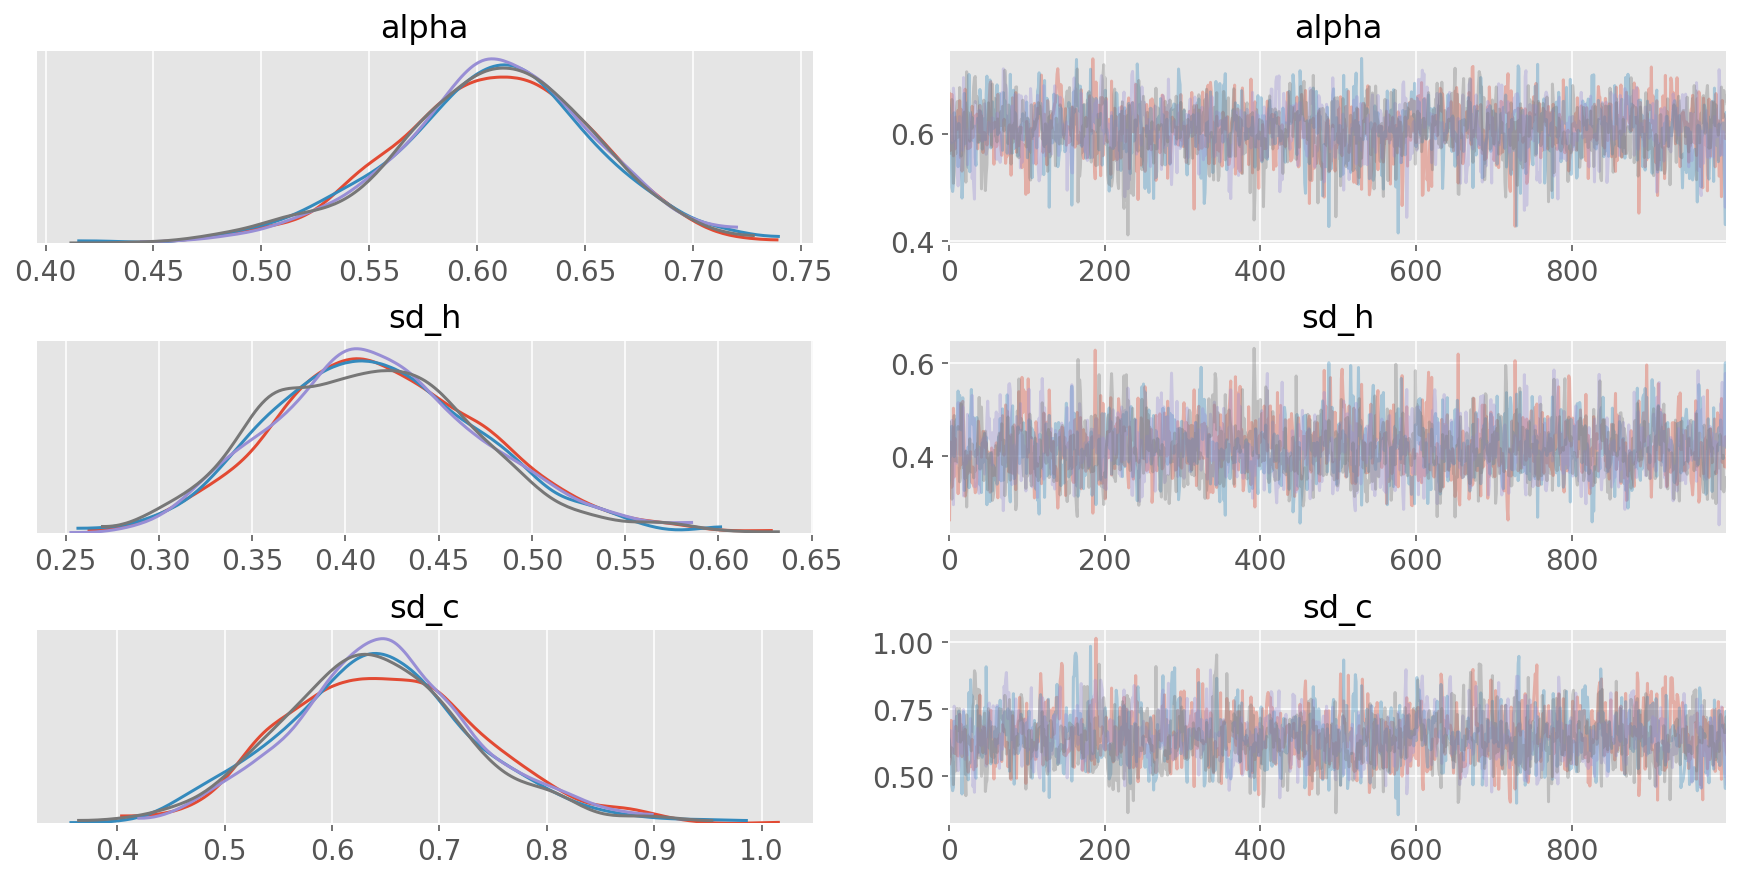

In [7]:
pm.traceplot(trace1, var_names=['alpha', 'sd_h', 'sd_c']);

We also got a lot of Rhat warning, that's because the Zero-centre phi introduce unidentification to the model:

In [8]:
summary1 = pm.summary(trace1)
summary1[summary1['Rhat']> 1.05]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_phi__0,-94.635429,395.941794,39.520197,-706.546685,425.310272,2.290128,3.282966
mu_phi__1,-94.710633,395.937772,39.519862,-706.179872,425.537379,2.290198,3.282518
mu_phi__2,-94.696526,395.934545,39.519490,-707.000483,424.911855,2.290127,3.283044
mu_phi__3,-95.463360,395.936198,39.519602,-707.830641,424.146044,2.290165,3.282657
mu_phi__4,-94.650018,395.942577,39.520316,-706.429326,425.368578,2.290142,3.282927
mu_phi__5,-94.792572,395.924556,39.518538,-706.578983,425.157702,2.290127,3.283019
mu_phi__6,-94.841536,395.933937,39.519507,-707.073765,424.784081,2.290160,3.282736
mu_phi__7,-94.773305,395.926884,39.518775,-706.900029,424.775060,2.290128,3.282985
mu_phi__8,-94.978114,395.934888,39.519543,-707.111584,424.793609,2.290153,3.282835
mu_phi__9,-94.969219,395.930949,39.519253,-707.069625,424.910324,2.290179,3.282653


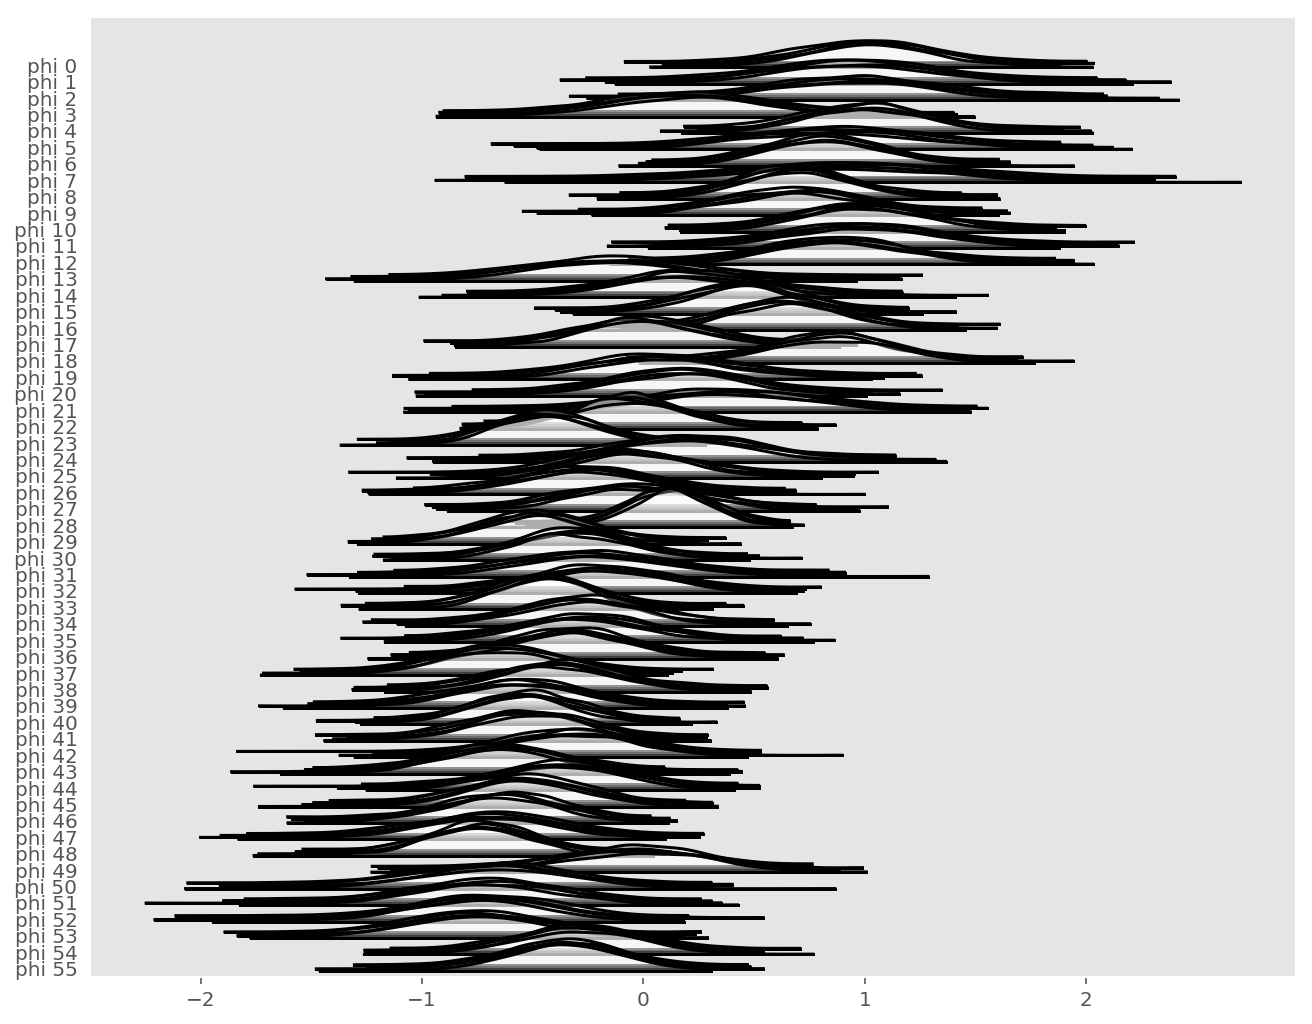

In [9]:
pm.plot_forest(trace1, 
               kind='ridgeplot', 
               var_names=['phi'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

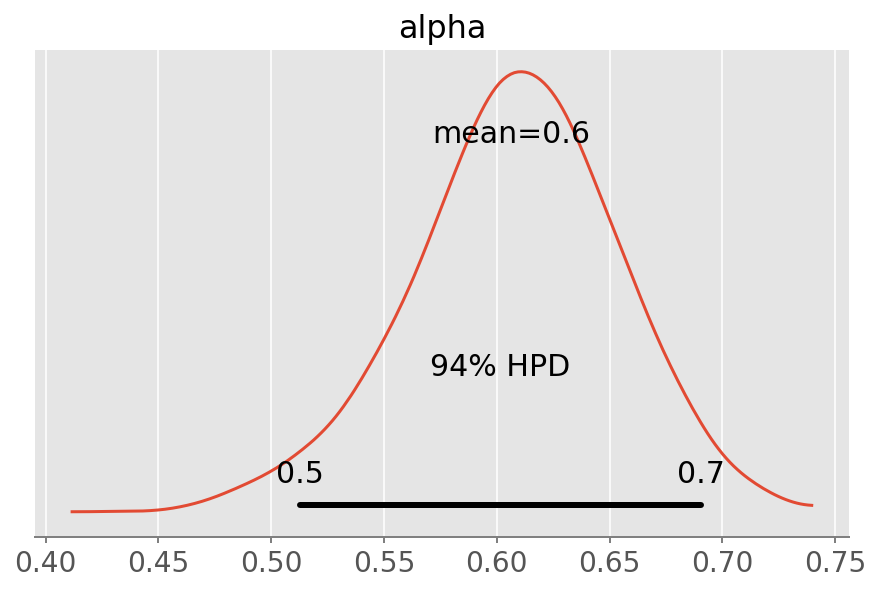

In [10]:
pm.plot_posterior(trace1, var_names=['alpha']);

`theano.scan` is much faster than using a python for loop, but it is still quite slow. One approach for improving it is to use linear algebra. That is, we should try to find a way to use matrix multiplication instead of looping (if you have experience in using MATLAB, it is the same philosophy). In our case, we can totally do that.  

For a similar problem, you can also have a look of [my port of Lee and Wagenmakers' book](https://github.com/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3). For example, in Chapter 19, the Stan code use [a for loop to generate the likelihood function](https://github.com/stan-dev/example-models/blob/master/Bayesian_Cognitive_Modeling/CaseStudies/NumberConcepts/NumberConcept_1_Stan.R#L28-L59), and I [generate the matrix outside and use matrix multiplication etc](http://nbviewer.jupyter.org/github/junpenglao/Bayesian-Cognitive-Modeling-in-Pymc3/blob/master/CaseStudies/NumberConceptDevelopment.ipynb#19.1-Knower-level-model-for-Give-N) to archive the same purpose.  

## PyMC3 implementation using matrix "trick"

Again, we try on some simulation data to make sure the implementation is correct.

In [11]:
maxwz = max([sum(w) for w in weights])
N = len(weights)
wmat2 = np.zeros((N, N))
amat2 = np.zeros((N, N), dtype='int32')
for i, a in enumerate(adj):
    amat2[i, a] = 1
    wmat2[i, a] = weights[i]

value = np.asarray(np.random.randn(N,), dtype=theano.config.floatX)

print(np.sum(value*amat2, axis=1)/np.sum(wmat2, axis=1))


def mu_phi(value):
    N = len(weights)
    # Calculate mu based on average of neighbours
    mu = np.array([np.sum(weights[i]*value[adj[i]])/Wplus[i] for i in range(N)])
    return mu

print(mu_phi(value))

[ 0.68218497  0.04580444 -1.48736701 -0.07438808 -0.10717181  0.14475881
 -0.05123007 -1.72778529  0.22697344  0.3244151   0.29335924  0.69567445
  0.10239117  0.42204059 -1.29736422 -0.04673205  0.02056937 -0.46614189
  0.42172308  0.28578853 -0.9697195   0.32652277  0.06359176 -0.25167944
 -1.17689333  0.14523651  0.32225614 -0.29541609  0.22663791  0.15648447
 -0.16440888  0.11774247 -0.14761774  0.46556113  0.09903074 -0.07947052
  0.09399804  0.50784957  0.70683648  0.01252083 -0.13926574 -0.38865019
 -0.46360071 -0.60276823 -1.35471336 -0.68394559 -0.25488506  0.09379293
 -0.09930071 -0.42247537  0.46728164  0.76639632 -0.54083931  0.10157048
 -0.18001542 -0.81280985]
[ 0.68218497  0.04580444 -1.48736701 -0.07438808 -0.10717181  0.14475881
 -0.05123007 -1.72778529  0.22697344  0.3244151   0.29335924  0.69567445
  0.10239117  0.42204059 -1.29736422 -0.04673205  0.02056937 -0.46614189
  0.42172308  0.28578853 -0.9697195   0.32652277  0.06359176 -0.25167944
 -1.17689333  0.14523651 

Now create a new CAR distribution with the matrix multiplication instead of `theano.scan` to get the `mu`

In [12]:
class CAR2(distribution.Continuous):
    """
    Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    a : adjacency matrix
    w : weight matrix
    tau : precision at each location
    """

    def __init__(self, w, a, tau, *args, **kwargs):
        super(CAR2, self).__init__(*args, **kwargs)
        self.a = a = tt.as_tensor_variable(a)
        self.w = w = tt.as_tensor_variable(w)
        self.tau = tau*tt.sum(w, axis=1)
        self.mode = 0.

    def logp(self, x):
        tau = self.tau
        w = self.w
        a = self.a

        mu_w = tt.sum(x*a, axis=1)/tt.sum(w, axis=1)
        return tt.sum(continuous.Normal.dist(mu=mu_w, tau=tau).logp(x))

In [13]:
with pm.Model() as model2:
    # Vague prior on intercept
    beta0 = pm.Normal('beta0', mu=0.0, tau=1.0e-5)
    # Vague prior on covariate effect
    beta1 = pm.Normal('beta1', mu=0.0, tau=1.0e-5)

    # Random effects (hierarchial) prior
    tau_h = pm.Gamma('tau_h', alpha=3.2761, beta=1.81)
    # Spatial clustering prior
    tau_c = pm.Gamma('tau_c', alpha=1.0, beta=1.0)

    # Regional random effects
    theta = pm.Normal('theta', mu=0.0, tau=tau_h, shape=N)
    mu_phi = CAR2('mu_phi', w=wmat2, a=amat2, tau=tau_c, shape=N)

    # Zero-centre phi
    phi = pm.Deterministic('phi', mu_phi-tt.mean(mu_phi))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(logE + beta0 + beta1*aff + theta + phi))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu, observed=O)

    # Marginal SD of heterogeniety effects
    sd_h = pm.Deterministic('sd_h', tt.std(theta))
    # Marginal SD of clustering (spatial) effects
    sd_c = pm.Deterministic('sd_c', tt.std(phi))
    # Proportion sptial variance
    alpha = pm.Deterministic('alpha', sd_c/(sd_h+sd_c))

    trace2 = pm.sample(1000, tune=500, cores=4, 
                       init='advi',
                       nuts_kwargs={"target_accept":0.9,
                                    "max_treedepth": 15})

Auto-assigning NUTS sampler...
Initializing NUTS using advi...
Average Loss = 200.59:   9%|▉         | 17706/200000 [00:13<02:20, 1294.16it/s]
Convergence achieved at 17800
Interrupted at 17,799 [8%]: Average Loss = 329.23
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_phi, theta, tau_c, tau_h, beta1, beta0]
Sampling 4 chains: 100%|██████████| 6000/6000 [01:15<00:00, 79.28draws/s] 
The gelman-rubin statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


**As you can see, it is appreciably faster using matrix multiplication.**

In [14]:
summary2 = pm.summary(trace2)
summary2[summary2['Rhat']> 1.05]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_phi__0,-98.796307,147.037983,14.553918,-482.458945,62.746624,6.739178,1.332132
mu_phi__1,-98.886964,147.028380,14.553049,-482.877963,62.432065,6.738262,1.332227
mu_phi__2,-98.853575,147.037379,14.553892,-482.780418,63.132308,6.739237,1.332141
mu_phi__3,-99.622138,147.029207,14.553174,-485.599994,59.924299,6.739981,1.332052
mu_phi__4,-98.806780,147.033069,14.553424,-482.596207,62.686976,6.739067,1.332153
mu_phi__5,-98.957113,147.024984,14.552760,-482.952603,62.800541,6.738680,1.332188
mu_phi__6,-99.004438,147.026891,14.552866,-482.558997,62.403068,6.738020,1.332248
mu_phi__7,-98.930512,147.025334,14.552812,-483.122587,62.778663,6.739144,1.332160
mu_phi__8,-99.148578,147.031256,14.553239,-482.750296,62.391668,6.738913,1.332167
mu_phi__9,-99.130665,147.018717,14.552024,-482.970935,62.025047,6.738440,1.332204


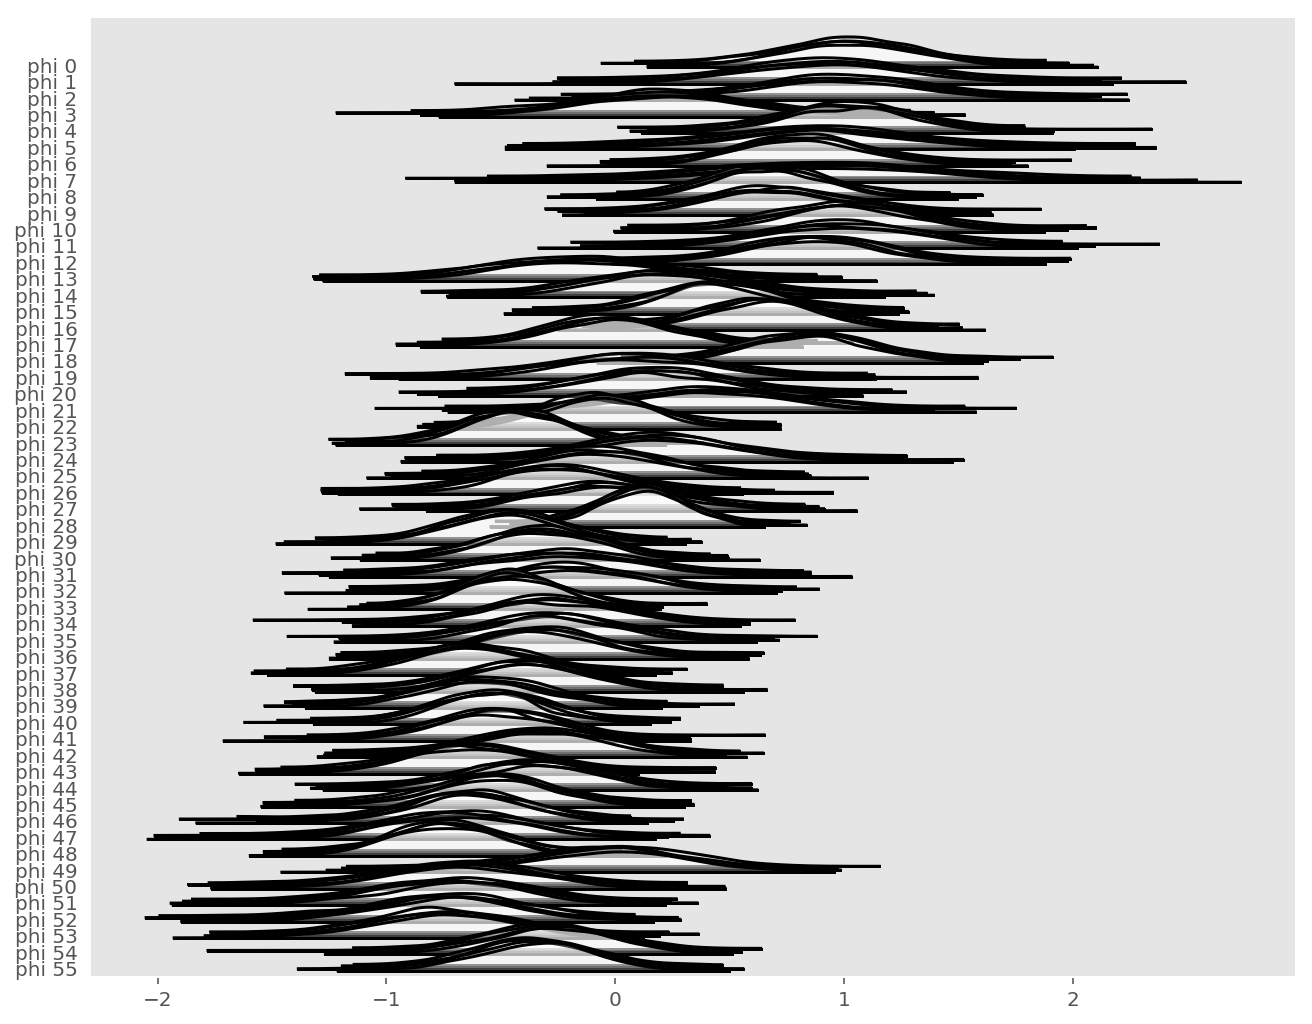

In [15]:
pm.plot_forest(trace2, 
               kind='ridgeplot', 
               var_names=['phi'],
               combined=False,
               ridgeplot_overlap=3,
               ridgeplot_alpha=.25,
               colors='white',
               figsize=(9, 7));

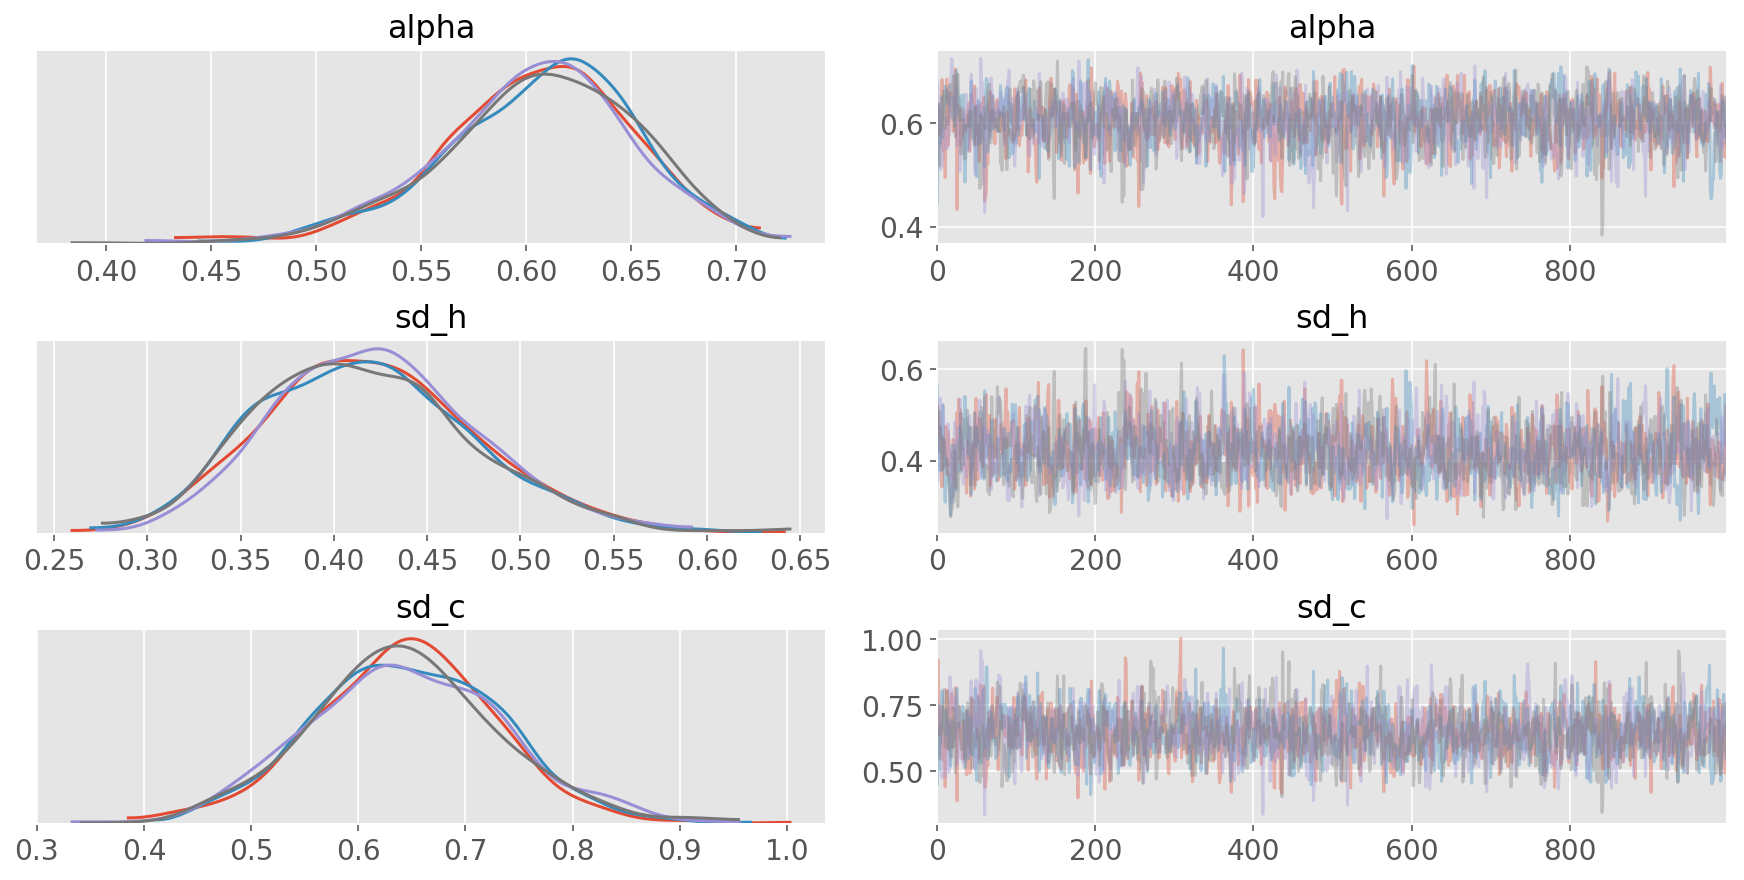

In [16]:
pm.traceplot(trace2, var_names=['alpha', 'sd_h', 'sd_c']);

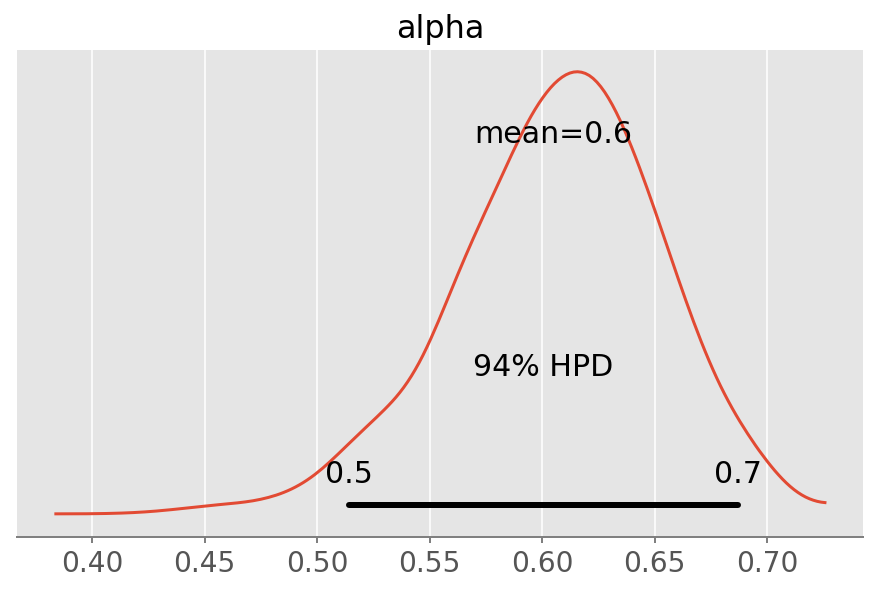

In [17]:
pm.plot_posterior(trace2, var_names=['alpha']);

## PyMC3 implementation using Matrix multiplication

There are almost always multiple ways to formulate a particular model. Some approaches work better than the others under different contexts (size of your dataset, properties of the sampler, etc). 

In this case, we can expressed the CAR prior as:  

$$\phi \sim \mathcal{N}(0, [D_\tau (I - \alpha B)]^{-1}).$$

You can find more details in the original [Stan case study](http://mc-stan.org/documentation/case-studies/mbjoseph-CARStan.html). You might come across similar constructs in Gaussian Process, which result in a zero-mean Gaussian distribution conditioned on a covariance function.

In the `Stan` Code, matrix D is generated in the model using a `transformed data{}` block:
```
transformed data{
  vector[n] zeros;
  matrix<lower = 0>[n, n] D;
  {
    vector[n] W_rowsums;
    for (i in 1:n) {
      W_rowsums[i] = sum(W[i, ]);
    }
    D = diag_matrix(W_rowsums);
  }
  zeros = rep_vector(0, n);
}
```
We can generate the same matrix quite easily:

In [18]:
X = np.hstack((np.ones((N, 1)), stats.zscore(aff, ddof=1)[:, None]))
W = wmat2
D = np.diag(W.sum(axis=1))
log_offset = logE[:, None]

Then in the `Stan` model:
```
model {
  phi ~ multi_normal_prec(zeros, tau * (D - alpha * W));
  ...
} 
```
since the precision matrix just generated by some matrix multiplication, we can do just that in `PyMC3`:

In [19]:
with pm.Model() as model3:
    # Vague prior on intercept and effect
    beta = pm.Normal('beta', mu=0.0, tau=1.0, shape=(2, 1))

    # Priors for spatial random effects
    tau = pm.Gamma('tau', alpha=2., beta=2.)
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    phi = pm.MvNormal('phi', mu=0, tau=tau*(D - alpha*W), shape=(1, N))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(tt.dot(X, beta) + phi.T + log_offset))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu.ravel(), observed=O)

    trace3 = pm.sample(1000, tune=2000, cores=4,
                       nuts_kwargs={"target_accept":0.85})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sampling 4 chains: 100%|██████████| 12000/12000 [08:15<00:00, 24.21draws/s]
The acceptance probability does not match the target. It is 0.9305266141546693, but should be close to 0.85. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9374411719241976, but should be close to 0.85. Try to increase the number of tuning steps.
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


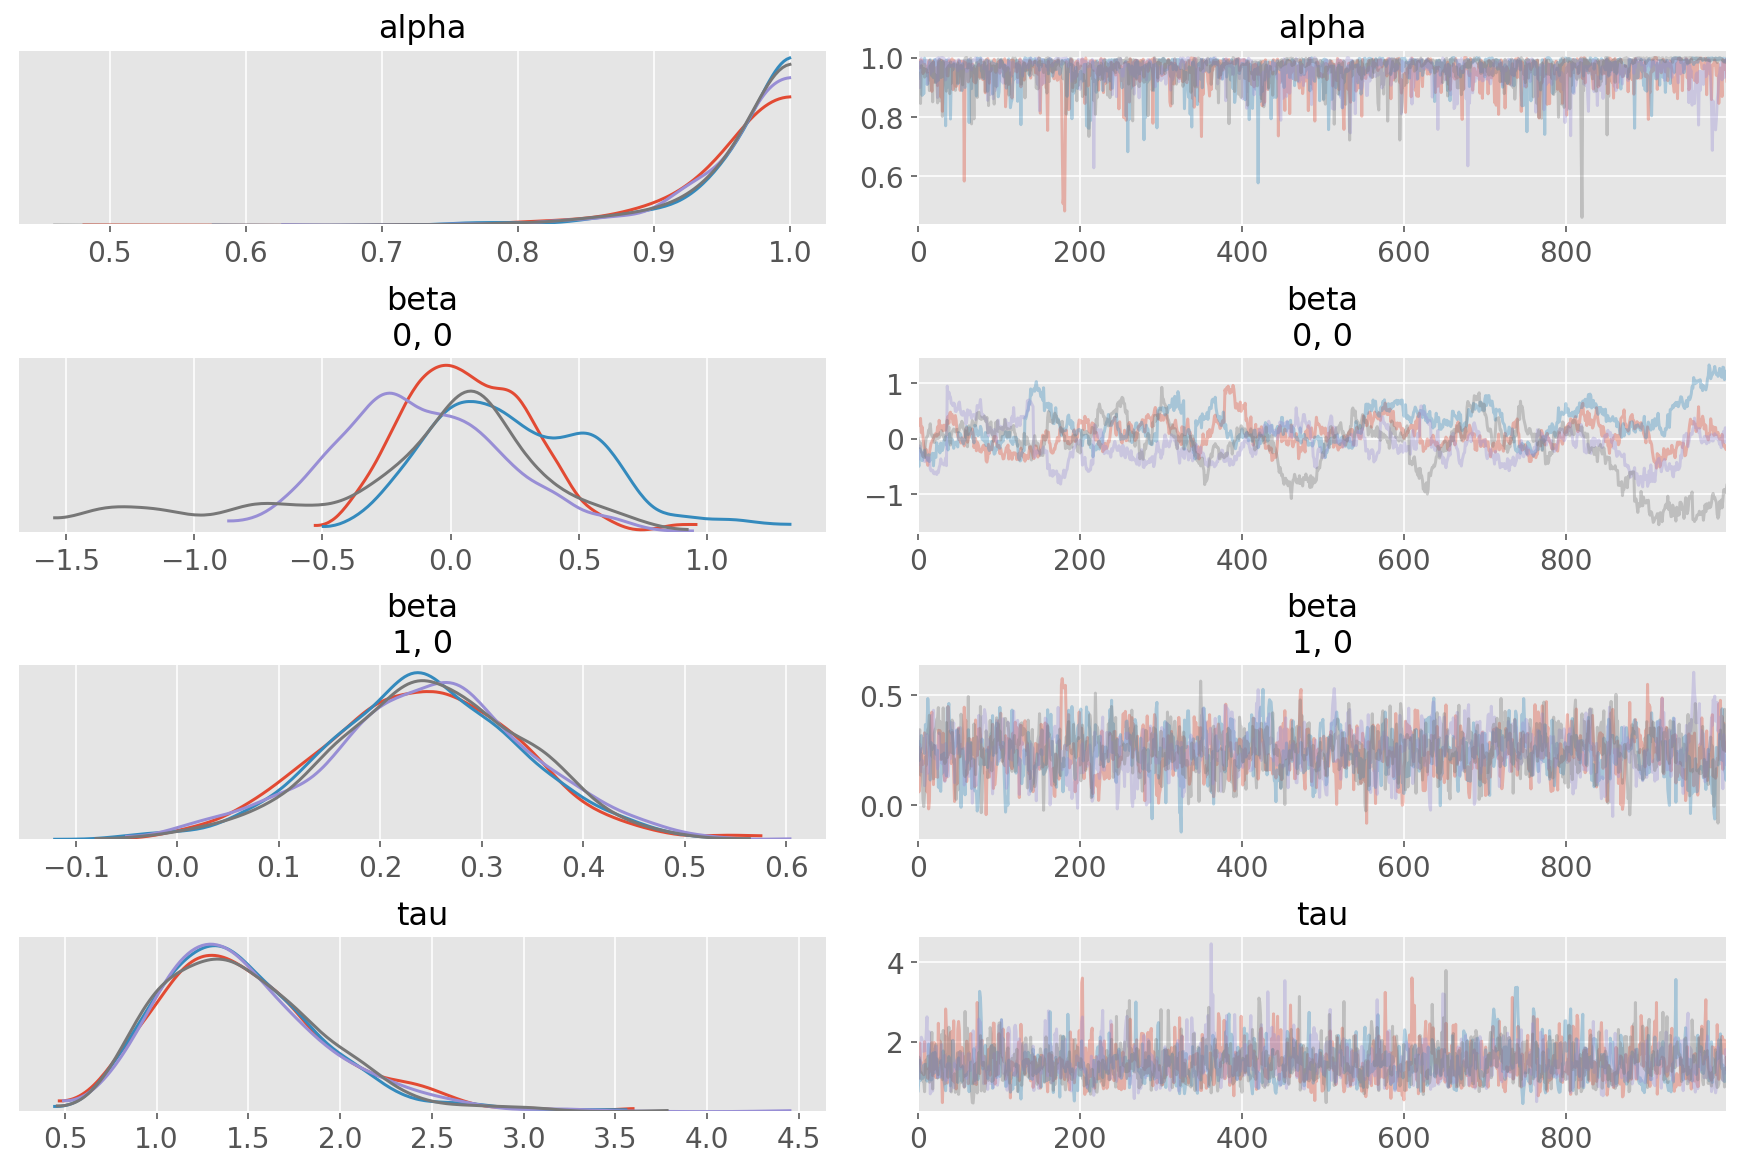

In [20]:
pm.traceplot(trace3, var_names=['alpha', 'beta', 'tau']);

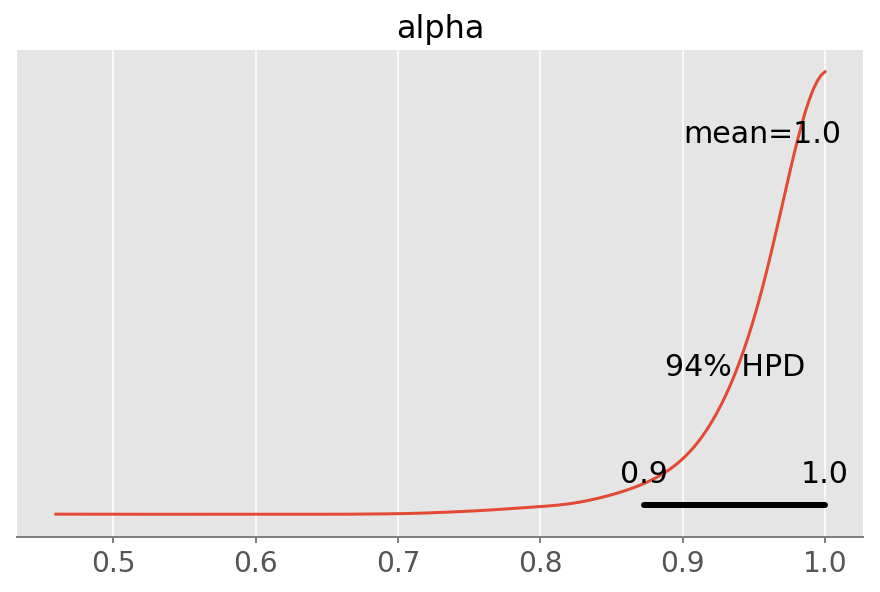

In [21]:
pm.plot_posterior(trace3, var_names=['alpha']);

Notice that since the model parameterization is different than in the `WinBUGS` model, the `alpha` can't be interpreted in the same way.

## PyMC3 implementation using Sparse Matrix

Note that in the node $\phi \sim \mathcal{N}(0, [D_\tau (I - \alpha B)]^{-1})$, we are computing the log-likelihood for a multivariate Gaussian distribution, which might not scale well in high-dimensions. We can take advantage of the fact that the covariance matrix here $[D_\tau (I - \alpha B)]^{-1}$ is **sparse**, and there are faster ways to compute its log-likelihood. 

For example, a more efficient sparse representation of the CAR in `Stan`:
```
functions {
  /**
  * Return the log probability of a proper conditional autoregressive (CAR) prior 
  * with a sparse representation for the adjacency matrix
  *
  * @param phi Vector containing the parameters with a CAR prior
  * @param tau Precision parameter for the CAR prior (real)
  * @param alpha Dependence (usually spatial) parameter for the CAR prior (real)
  * @param W_sparse Sparse representation of adjacency matrix (int array)
  * @param n Length of phi (int)
  * @param W_n Number of adjacent pairs (int)
  * @param D_sparse Number of neighbors for each location (vector)
  * @param lambda Eigenvalues of D^{-1/2}*W*D^{-1/2} (vector)
  *
  * @return Log probability density of CAR prior up to additive constant
  */
  real sparse_car_lpdf(vector phi, real tau, real alpha, 
    int[,] W_sparse, vector D_sparse, vector lambda, int n, int W_n) {
      row_vector[n] phit_D; // phi' * D
      row_vector[n] phit_W; // phi' * W
      vector[n] ldet_terms;
    
      phit_D = (phi .* D_sparse)';
      phit_W = rep_row_vector(0, n);
      for (i in 1:W_n) {
        phit_W[W_sparse[i, 1]] = phit_W[W_sparse[i, 1]] + phi[W_sparse[i, 2]];
        phit_W[W_sparse[i, 2]] = phit_W[W_sparse[i, 2]] + phi[W_sparse[i, 1]];
      }
    
      for (i in 1:n) ldet_terms[i] = log1m(alpha * lambda[i]);
      return 0.5 * (n * log(tau)
                    + sum(ldet_terms)
                    - tau * (phit_D * phi - alpha * (phit_W * phi)));
  }
}
```
with the data transformed in the model:
```
transformed data {
  int W_sparse[W_n, 2];   // adjacency pairs
  vector[n] D_sparse;     // diagonal of D (number of neigbors for each site)
  vector[n] lambda;       // eigenvalues of invsqrtD * W * invsqrtD
  
  { // generate sparse representation for W
  int counter;
  counter = 1;
  // loop over upper triangular part of W to identify neighbor pairs
    for (i in 1:(n - 1)) {
      for (j in (i + 1):n) {
        if (W[i, j] == 1) {
          W_sparse[counter, 1] = i;
          W_sparse[counter, 2] = j;
          counter = counter + 1;
        }
      }
    }
  }
  for (i in 1:n) D_sparse[i] = sum(W[i]);
  {
    vector[n] invsqrtD;  
    for (i in 1:n) {
      invsqrtD[i] = 1 / sqrt(D_sparse[i]);
    }
    lambda = eigenvalues_sym(quad_form(W, diag_matrix(invsqrtD)));
  }
}
```
and the likelihood:
```
model {
  phi ~ sparse_car(tau, alpha, W_sparse, D_sparse, lambda, n, W_n);
}
```

This is quite a lot of code to digest, so my general approach is to compare the intermediate steps (whenever possible) with `Stan`. In this case, I will try to compute `tau, alpha, W_sparse, D_sparse, lambda, n, W_n` outside of the `Stan` model in `R` and compare with my own implementation.  

Below is a Sparse CAR implementation in `PyMC3` ([see also here](https://github.com/pymc-devs/pymc3/issues/2066#issuecomment-296397012)). Again, we try to avoid using any looping, as in `Stan`.

In [22]:
import scipy

class Sparse_CAR(distribution.Continuous):
    """
    Sparse Conditional Autoregressive (CAR) distribution

    Parameters
    ----------
    alpha : spatial smoothing term
    W : adjacency matrix
    tau : precision at each location
    """

    def __init__(self, alpha, W, tau, *args, **kwargs):
        self.alpha = alpha = tt.as_tensor_variable(alpha)
        self.tau = tau = tt.as_tensor_variable(tau)
        D = W.sum(axis=0)
        n, m = W.shape
        self.n = n
        self.median = self.mode = self.mean = 0
        super(Sparse_CAR, self).__init__(*args, **kwargs)

        # eigenvalues of D^−1/2 * W * D^−1/2
        Dinv_sqrt = np.diag(1 / np.sqrt(D))
        DWD = np.matmul(np.matmul(Dinv_sqrt, W), Dinv_sqrt)
        self.lam = scipy.linalg.eigvalsh(DWD)

        # sparse representation of W
        w_sparse = scipy.sparse.csr_matrix(W)
        self.W = theano.sparse.as_sparse_variable(w_sparse)
        self.D = tt.as_tensor_variable(D)

        # Presicion Matrix (inverse of Covariance matrix)
        # d_sparse = scipy.sparse.csr_matrix(np.diag(D))
        # self.D = theano.sparse.as_sparse_variable(d_sparse)
        # self.Phi = self.tau * (self.D - self.alpha*self.W)

    def logp(self, x):
        logtau = self.n * tt.log(tau)
        logdet = tt.log(1 - self.alpha * self.lam).sum()

        # tau * ((phi .* D_sparse)' * phi - alpha * (phit_W * phi))
        Wx = theano.sparse.dot(self.W, x)
        tau_dot_x = self.D * x.T - self.alpha * Wx.ravel()
        logquad = self.tau * tt.dot(x.ravel(), tau_dot_x.ravel())

        # logquad = tt.dot(x.T, theano.sparse.dot(self.Phi, x)).sum()
        return 0.5*(logtau + logdet - logquad)

In [30]:
with pm.Model() as model4:
    # Vague prior on intercept and effect
    beta = pm.Normal('beta', mu=0.0, tau=1.0, shape=(2, 1))

    # Priors for spatial random effects
    tau = pm.Gamma('tau', alpha=2., beta=2.)
    alpha = pm.Uniform('alpha', lower=0, upper=1)
    phi = Sparse_CAR('phi', alpha, W, tau, shape=(N, 1))

    # Mean model
    mu = pm.Deterministic('mu', tt.exp(tt.dot(X, beta) + phi + log_offset))

    # Likelihood
    Yi = pm.Poisson('Yi', mu=mu.ravel(), observed=O)

    trace4 = pm.sample(1000, tune=2000, cores=4,
                       nuts_kwargs={"target_accept":0.85})

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [phi, alpha, tau, beta]
Sampling 4 chains: 100%|██████████| 12000/12000 [00:23<00:00, 500.87draws/s]
The estimated number of effective samples is smaller than 200 for some parameters.


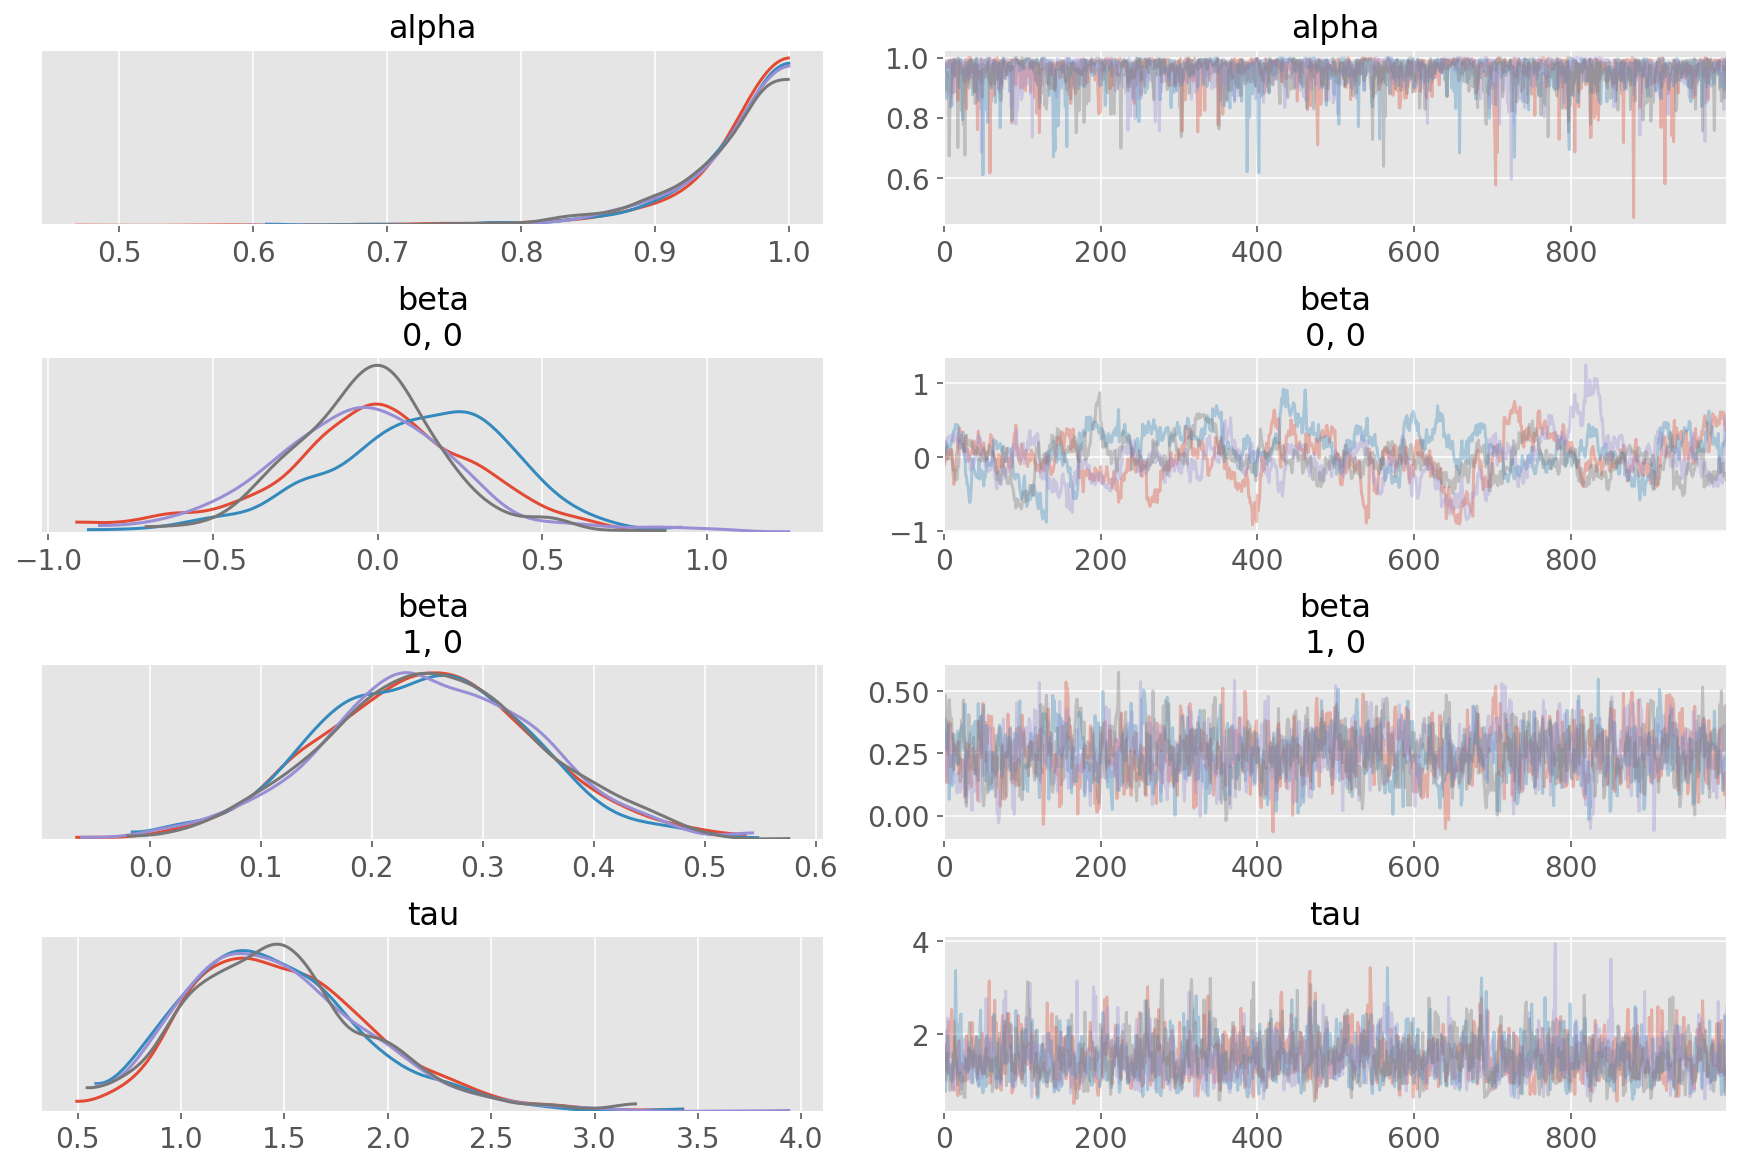

In [31]:
pm.traceplot(trace4, var_names=['alpha', 'beta', 'tau']);

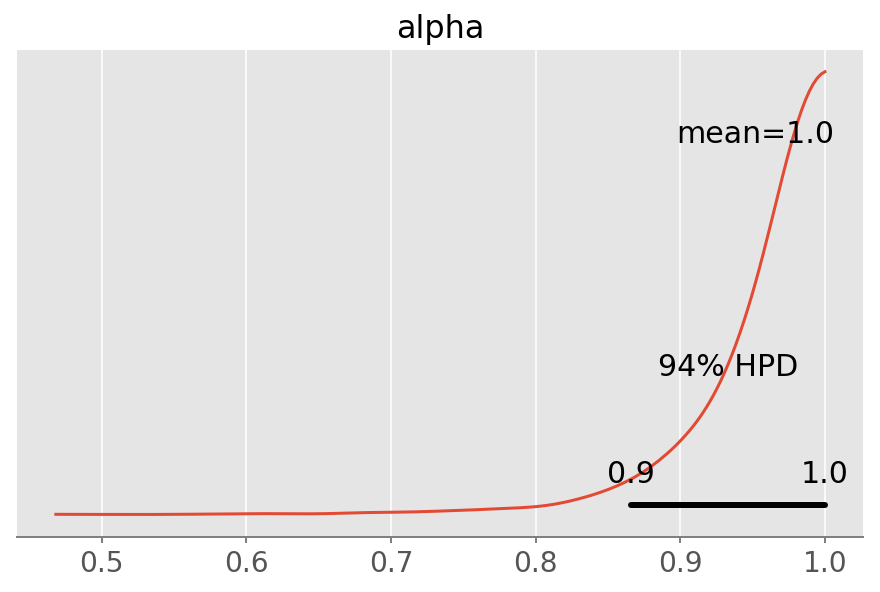

In [32]:
pm.plot_posterior(trace4, var_names=['alpha']);

As you can see above, the sparse representation returns the same estimates, while being much faster than any other implementation. 

## A few other warnings
In `Stan`, there is an option to write a `generated quantities` block for sample generation. Doing the similar in pymc3, however, is not recommended.  

Consider the following simple sample:
```python
# Data
x = np.array([1.1, 1.9, 2.3, 1.8])
n = len(x)

with pm.Model() as model1:
    # prior
    mu = pm.Normal('mu', mu=0, tau=.001)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    # observed
    xi = pm.Normal('xi', mu=mu, tau=1/(sigma**2), observed=x)
    # generation 
    p = pm.Deterministic('p', pm.math.sigmoid(mu))
    count = pm.Binomial('count', n=10, p=p, shape=10)
```
where we intended to use 
```python
count = pm.Binomial('count', n=10, p=p, shape=10)```
to generate posterior prediction. However, if the new RV added to the model is a discrete variable it can cause weird turbulence to the trace. You can see [issue #1990](https://github.com/pymc-devs/pymc3/issues/1990) for related discussion.

## Final remarks

In this notebook, most of the parameter conventions (e.g., using `tau` when defining a Normal distribution) and choice of priors are strictly matched with the original code in `Winbugs` or `Stan`. However, it is important to note that merely porting the code from one probabilistic programming language to the another is not necessarily the best practice. The aim is not just to run the code in `PyMC3`, but to make sure the model is appropriate so that it returns correct estimates, and runs efficiently (fast sampling). 

For example, as [@aseyboldt](https://github.com/aseyboldt) pointed out [here](https://github.com/pymc-devs/pymc3/pull/2080#issuecomment-297456574) and [here](https://github.com/pymc-devs/pymc3/issues/1924#issue-215496293), non-centered parametrizations are often a better choice than the centered parametrizations. In our case here, `phi` is following a zero-mean Normal distribution, thus it can be left out in the beginning and used to scale the values afterwards. Often, doing this can avoid correlations in the posterior (it will be slower in some cases, however).  

Another thing to keep in mind is that models can be sensitive to choices of prior distributions; for example, you can have a hard time using Normal variables with a large sd as prior. Gelman often recommends Cauchy or StudentT (*i.e.*, weakly-informative priors). More information on prior choice can be found on the [Stan wiki](https://github.com/stan-dev/stan/wiki/Prior-Choice-Recommendations).  

There are always ways to improve  code. Since our computational graph with `pm.Model()` consist of `theano` objects, we can always do `print(VAR_TO_CHECK.tag.test_value)` right after the declaration or computation to check the shape. 
For example, in our last example, as suggested by [@aseyboldt](https://github.com/pymc-devs/pymc3/pull/2080#issuecomment-297456574) there seem to be a lot of correlation in the posterior. That probably slows down NUTS quite a bit. As a debugging tool and guide for reparametrization you can look at the singular value decomposition of the standardized samples from the trace – basically the eigenvalues of the correlation matrix. If the problem is high dimensional you can use stuff from `scipy.sparse.linalg` to only compute the largest singular value: 

```python
from scipy import linalg, sparse

vals = np.array([model.dict_to_array(v) for v in trace[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = sparse.linalg.svds(vals, k=20)
```

Then look at `plt.plot(S)` to see if any principal components are obvious, and check which variables are contributing by looking at the singular vectors: `plt.plot(U[:, -1] ** 2)`. You can get the indices by looking at `model.bijection.ordering.vmap`.

Another great way to check the correlations in the posterior is to do a pairplot of the posterior (if your model doesn't contain too many parameters). You can see quite clearly if and where the the posterior parameters are correlated.

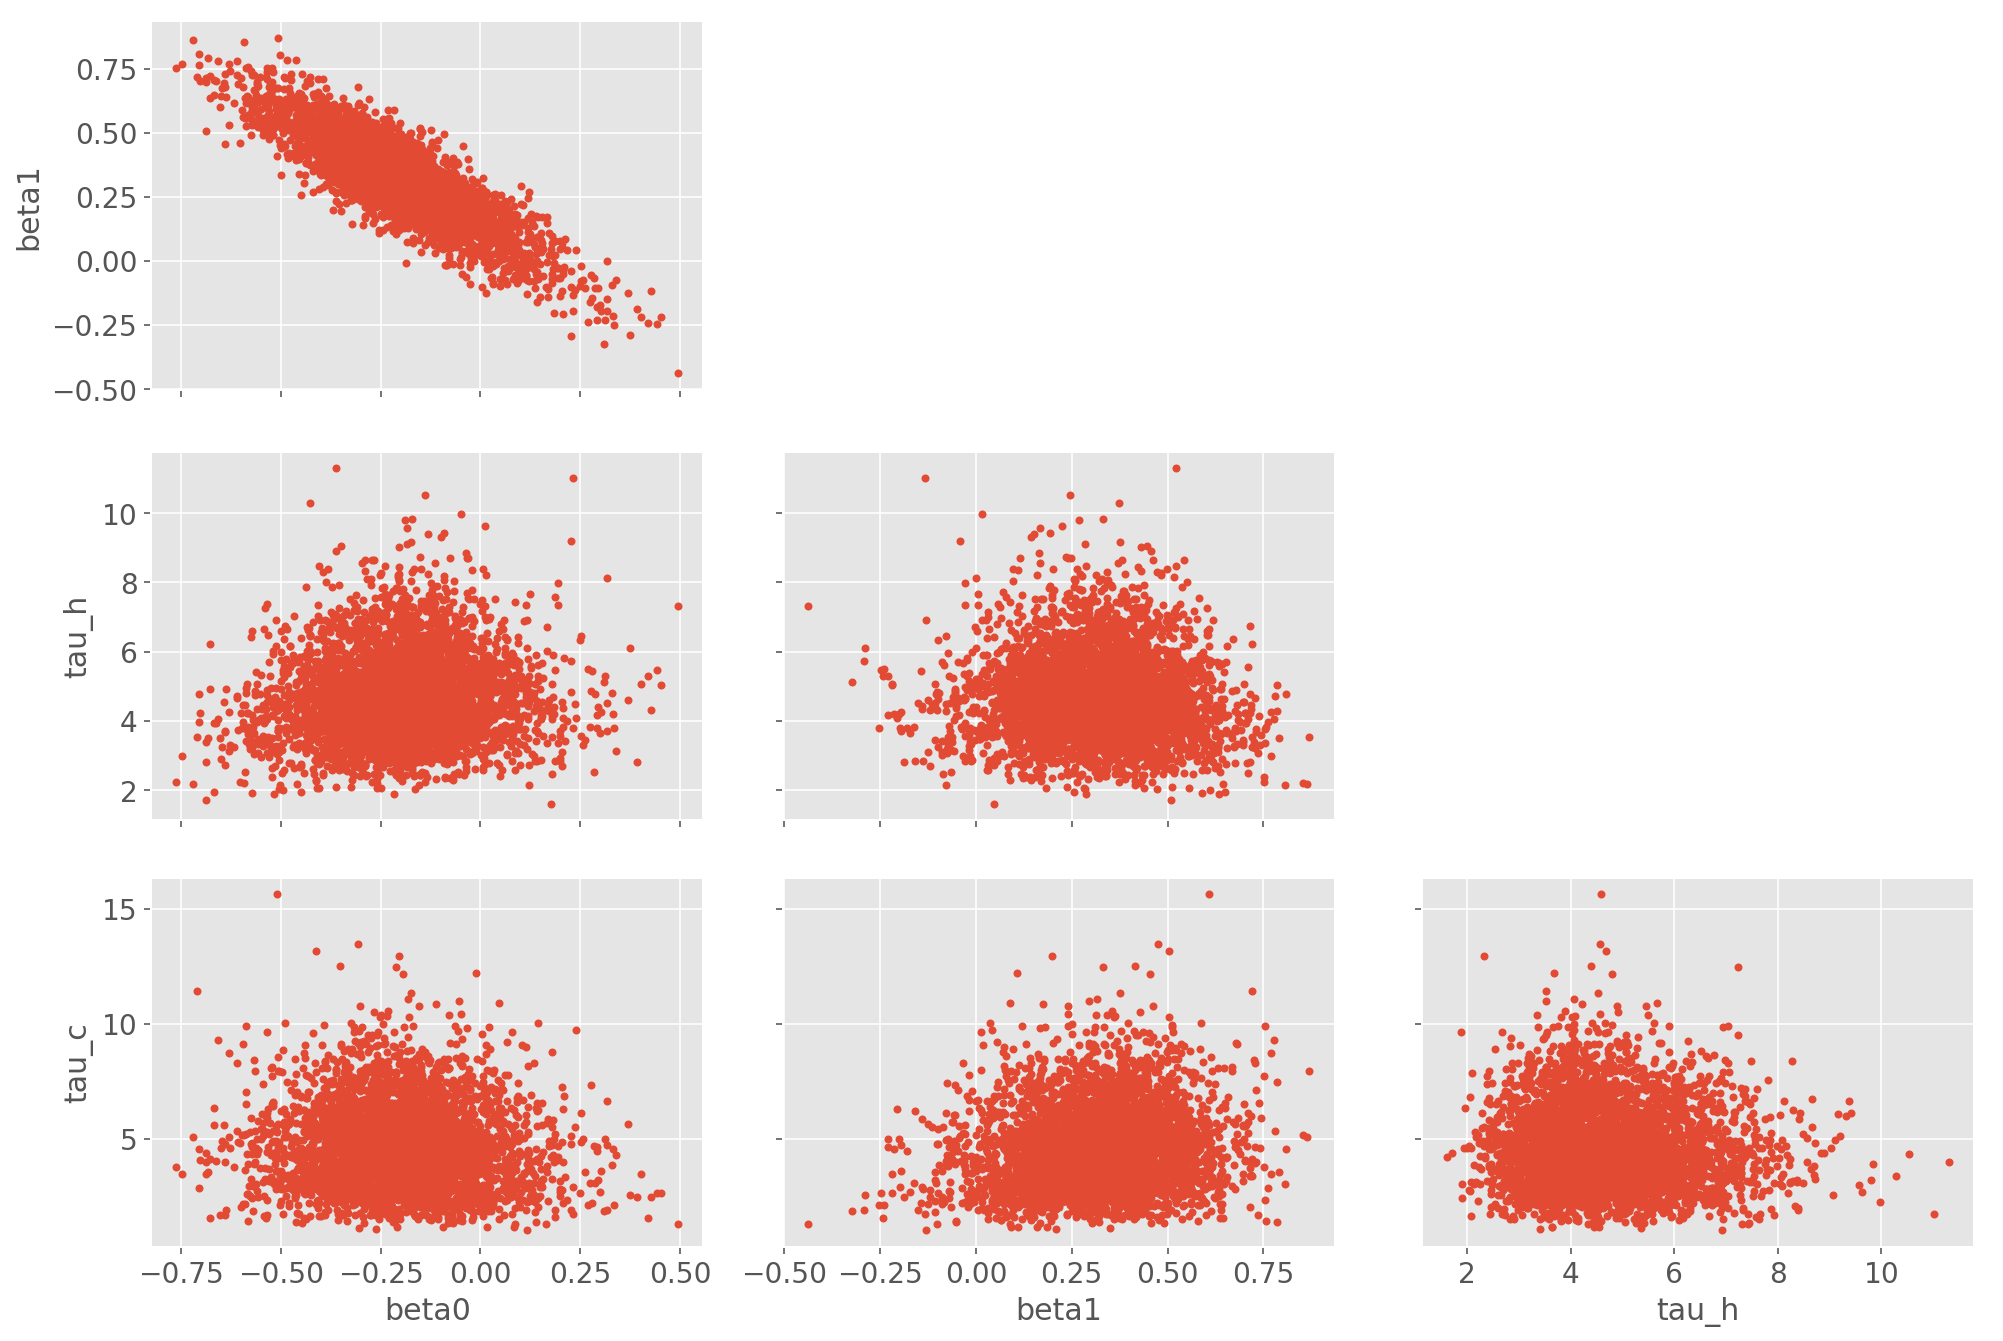

In [33]:
pm.pairplot(trace1, var_names=['beta0', 'beta1', 'tau_h', 'tau_c'], divergences=True);

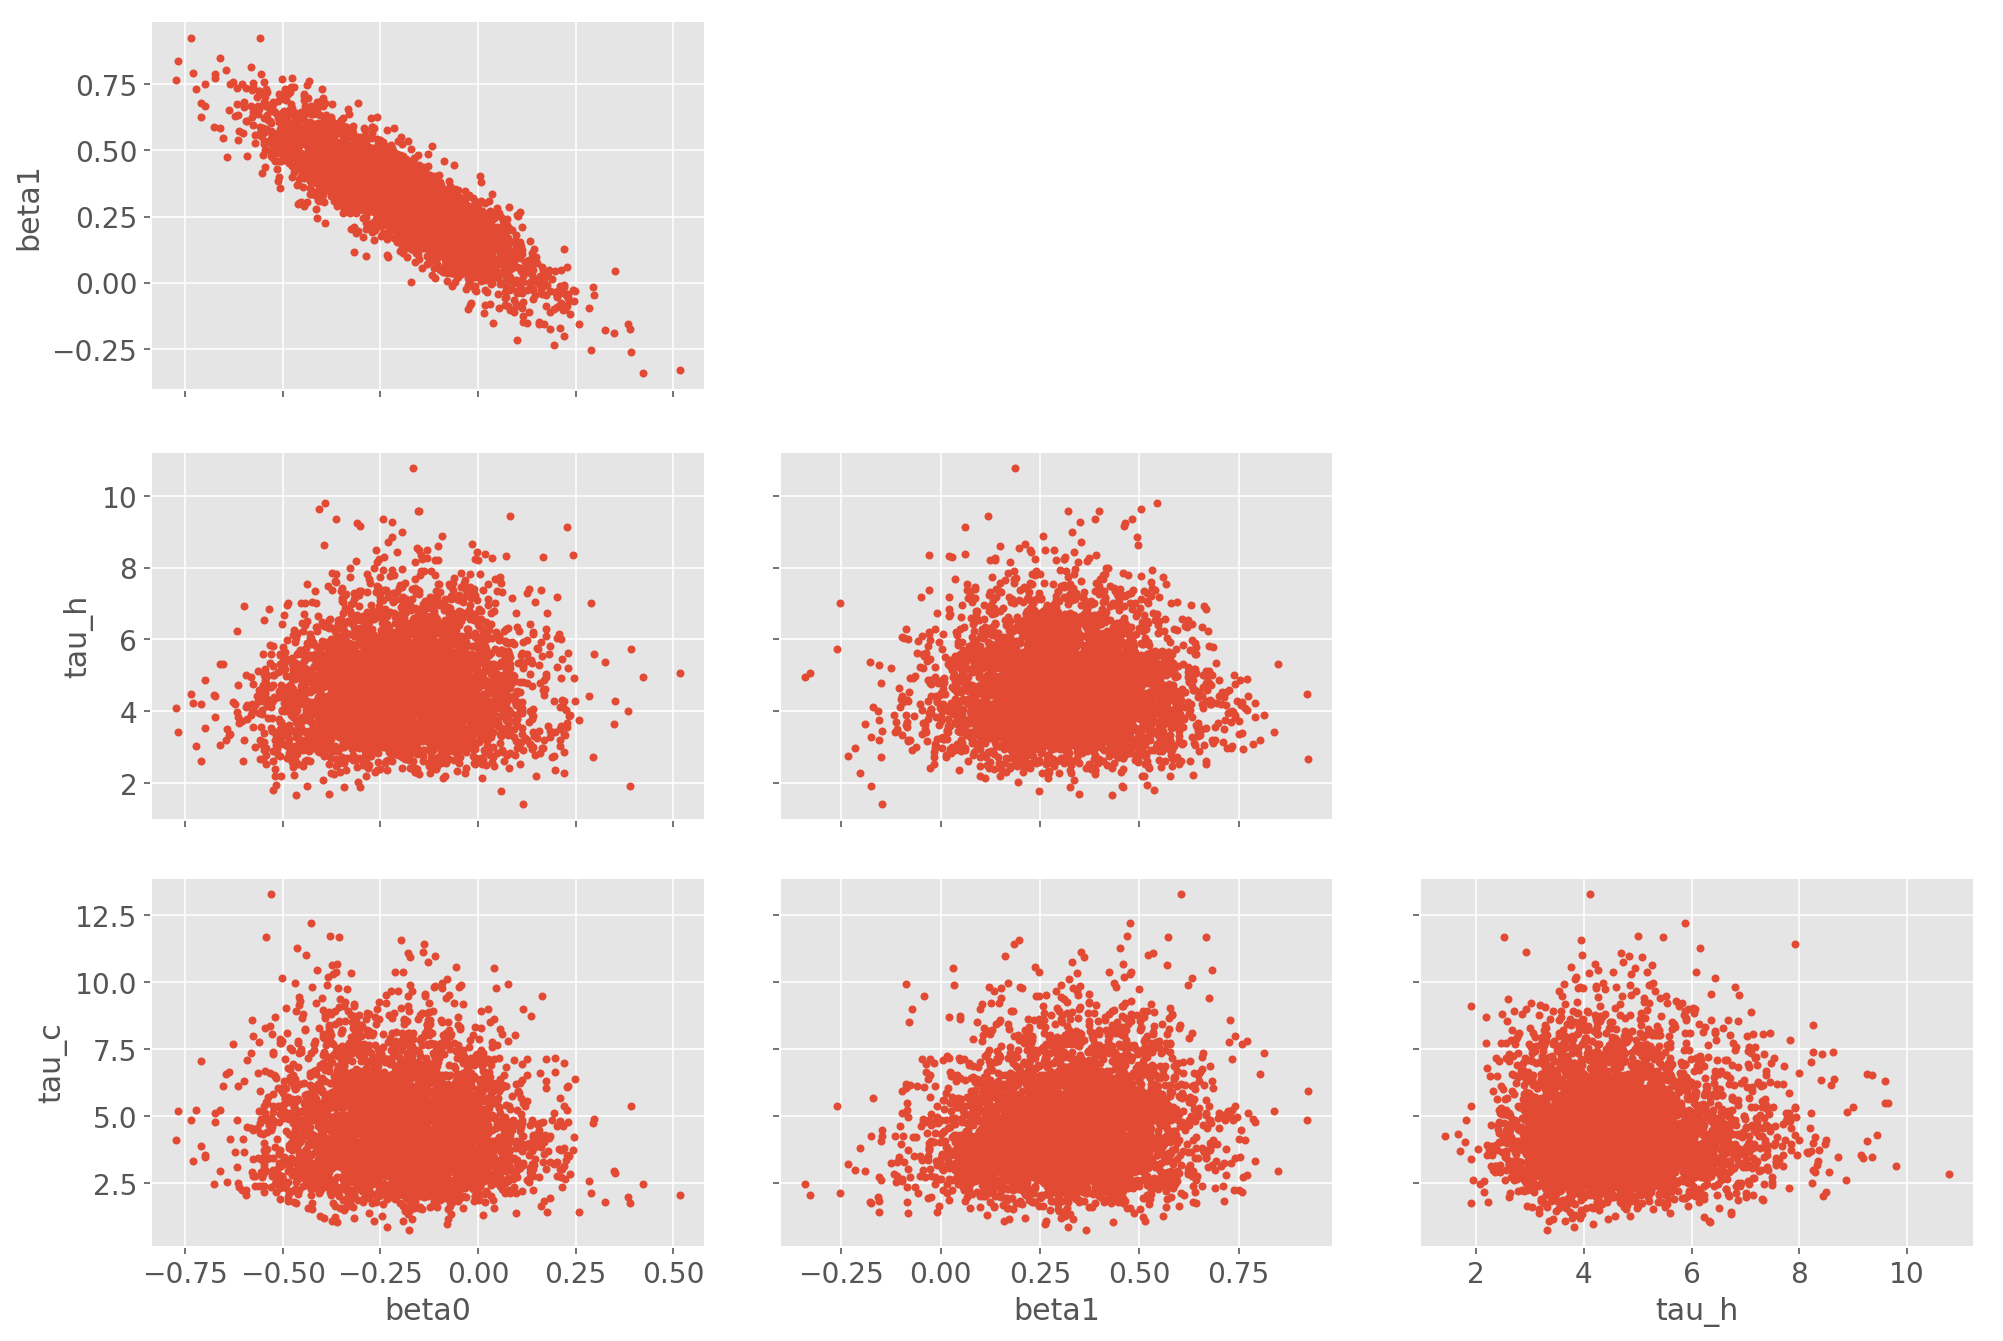

In [34]:
pm.pairplot(trace2, var_names=['beta0', 'beta1', 'tau_h', 'tau_c'], divergences=True);

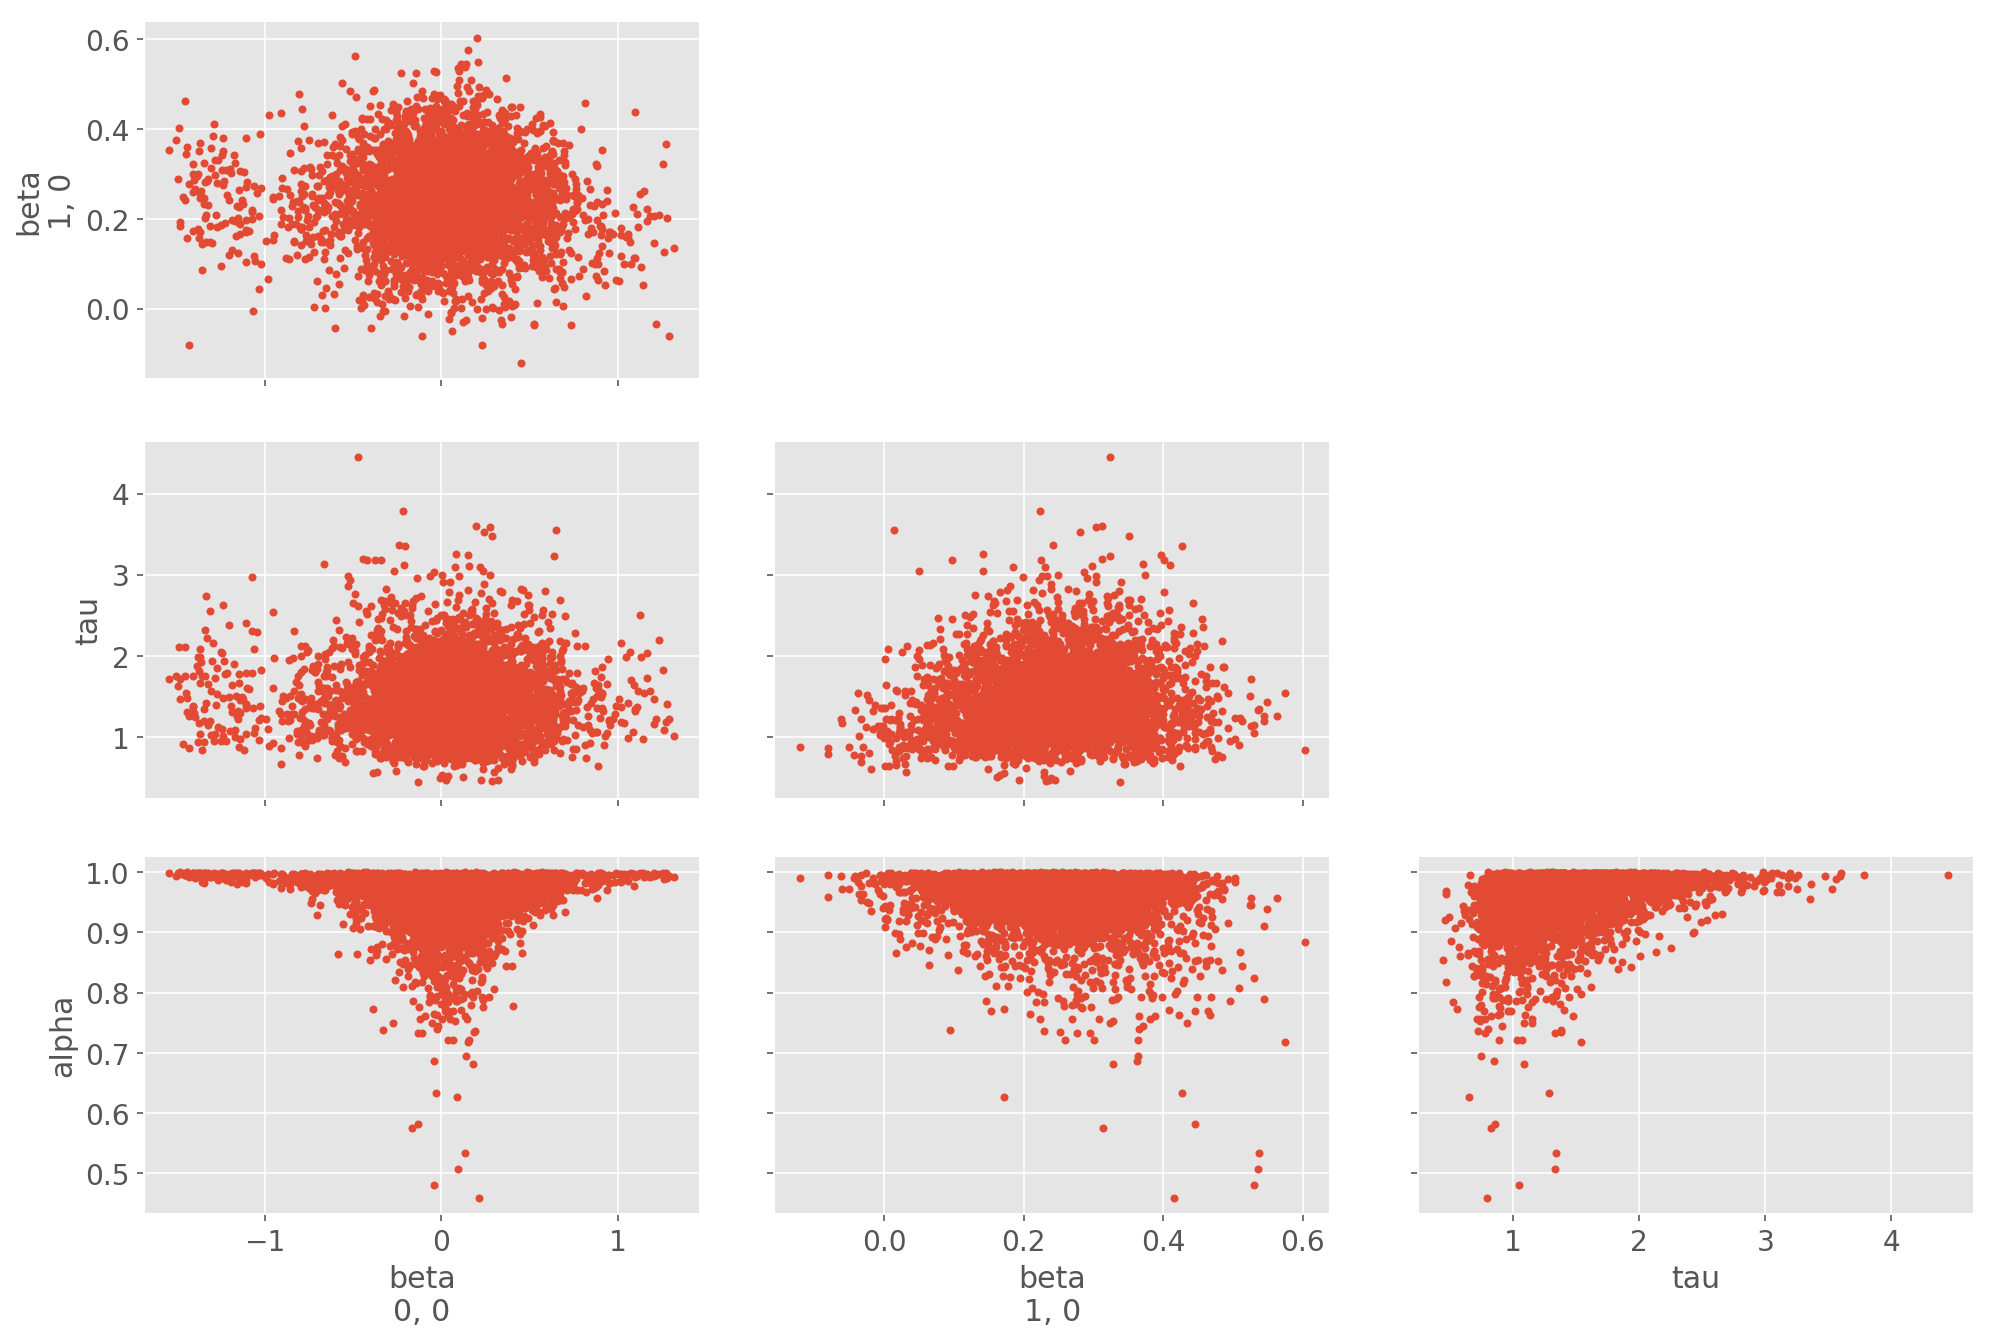

In [35]:
pm.pairplot(trace3, var_names=['beta', 'tau', 'alpha'], divergences=True);

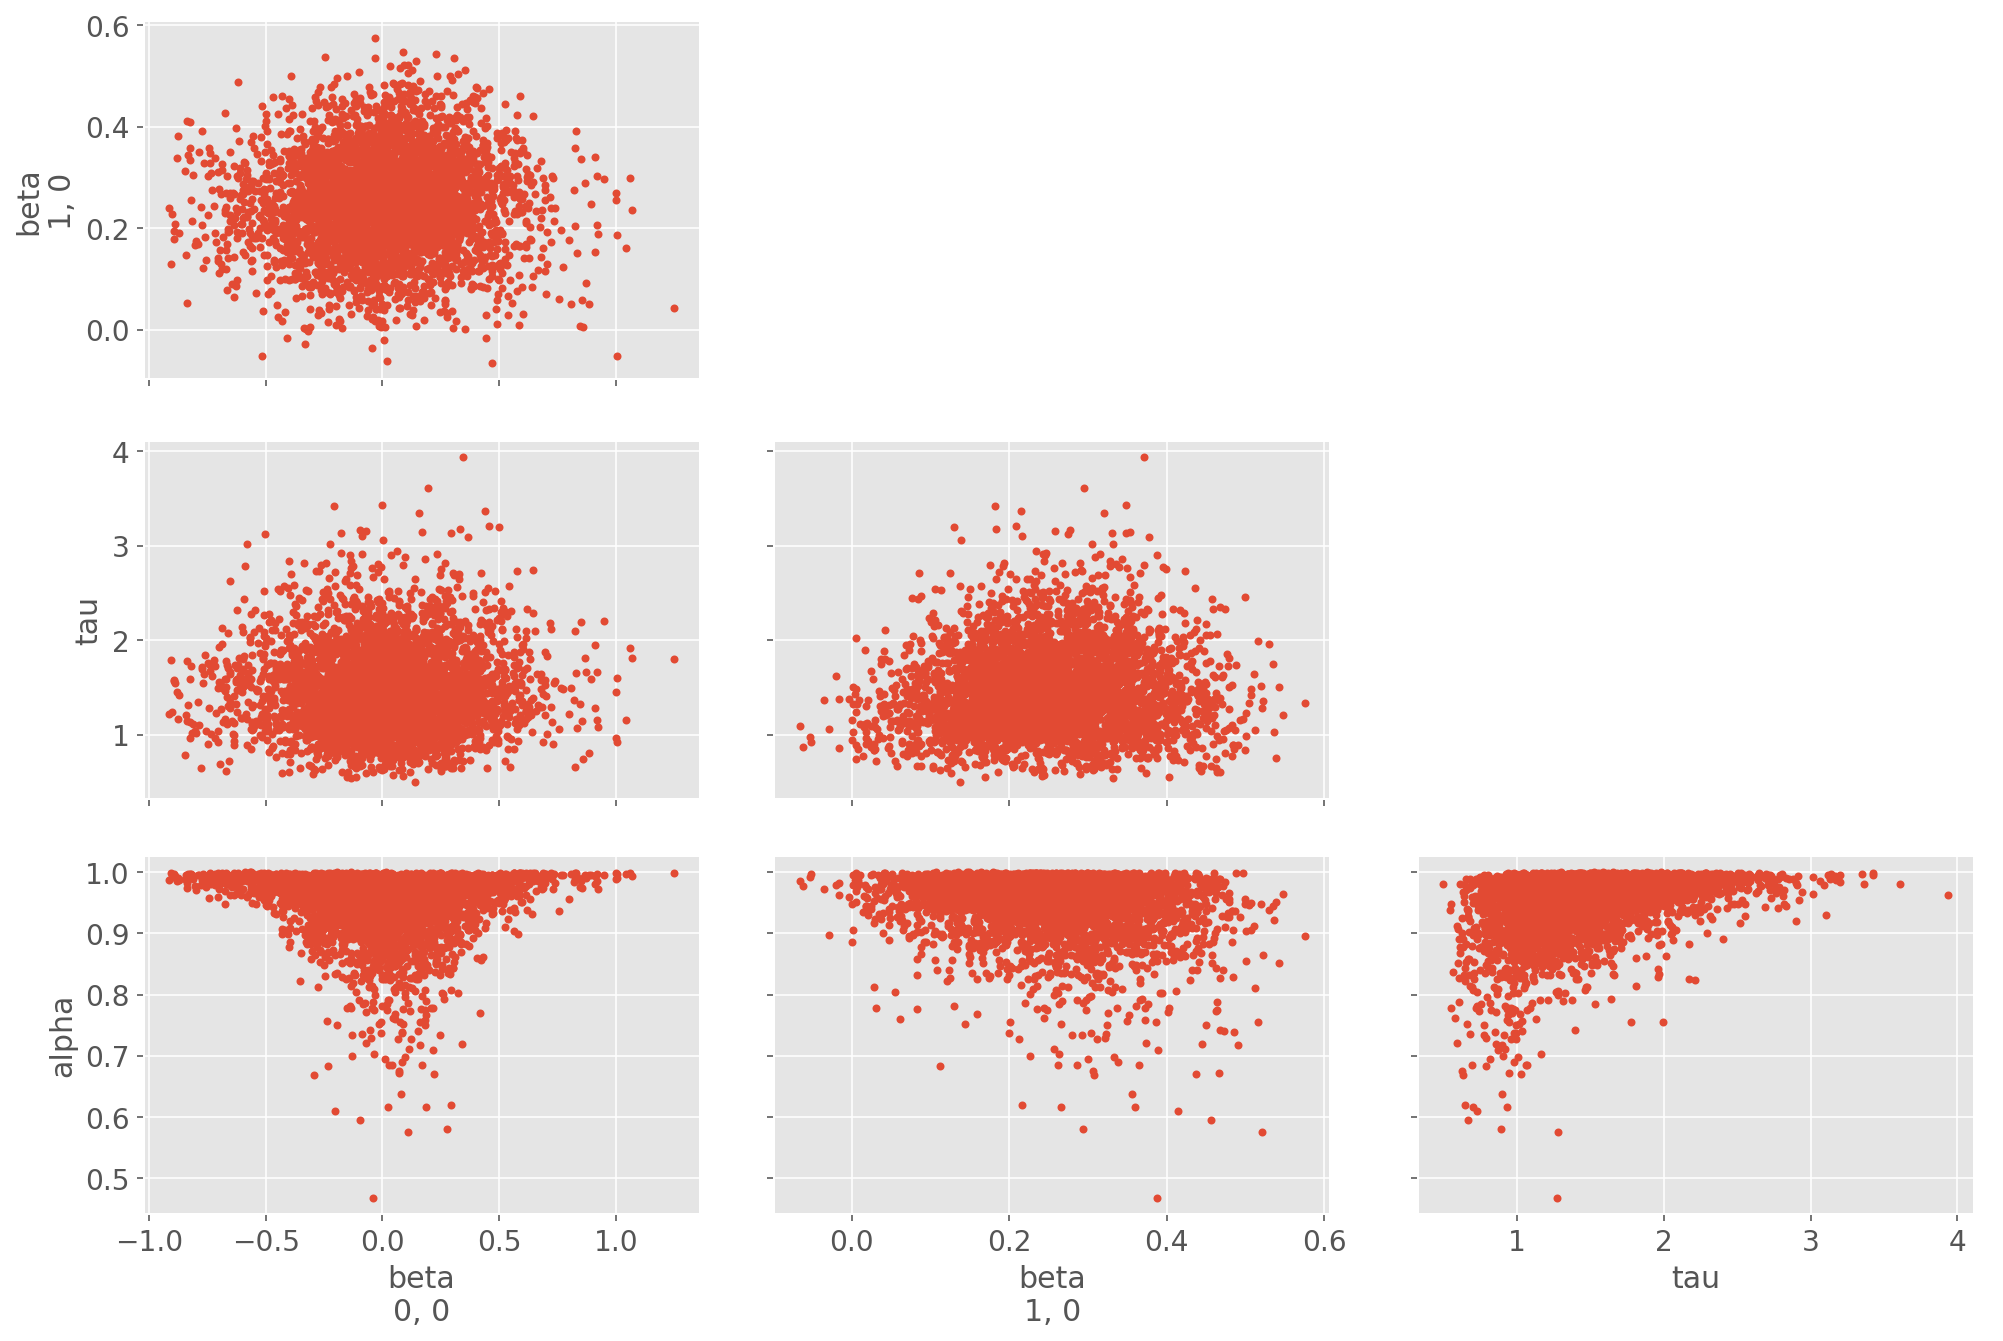

In [36]:
pm.pairplot(trace4, var_names=['beta', 'tau', 'alpha'], divergences=True);

* Notebook Written by [Junpeng Lao](https://www.github.com/junpenglao/), inspired by `PyMC3` [issue#2022](https://github.com/pymc-devs/pymc3/issues/2022), [issue#2066](https://github.com/pymc-devs/pymc3/issues/2066) and [comments](https://github.com/pymc-devs/pymc3/issues/2066#issuecomment-296397012). I would like to thank [@denadai2](https://github.com/denadai2), [@aseyboldt](https://github.com/aseyboldt), and [@twiecki](https://github.com/twiecki) for the helpful discussion.

In [47]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3   3.8
arviz   0.7.0
pandas  0.25.3
seaborn 0.9.0
numpy   1.17.5
last updated: Wed Apr 22 2020 

CPython 3.8.0
IPython 7.11.0
watermark 2.0.2
